# New GraphVAE

### Data preprocessing

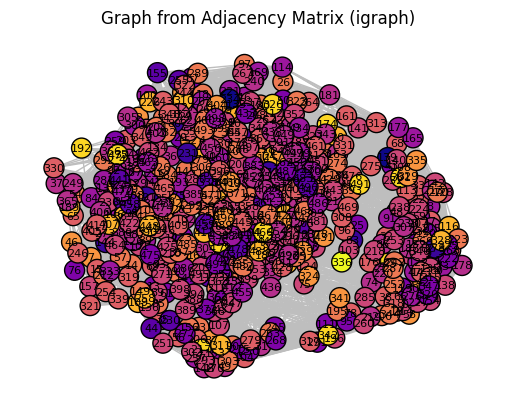

Successfully loaded matrix from data/SMS/wavy2-500/sim_9886/wavy_p_matrix.csv using np.loadtxt().


In [1]:
import numpy as np

from framework.SMS import import_dataset_fromSMS, plot_graph_from_adjacency_matrix

datasetSMS = import_dataset_fromSMS("data/SMS/wavy2-500/")

sim = list(datasetSMS.keys())[0]
mat = datasetSMS[sim]['adjacency_matrix']
num_nodes = mat.shape[0]
p_vectors_array = datasetSMS[sim]['p_array']
dimP = p_vectors_array.shape[1]


plot_graph_from_adjacency_matrix(mat, node_color_scalars=np.sum(p_vectors_array, axis=1), cmap='plasma')

def read_matrix_from_csv_loadtxt(filepath, delimiter=','):
  """
  Reads a NumPy matrix from a CSV file using np.loadtxt().

  Args:
    filepath (str): The path to the CSV file.
    delimiter (str): The character separating values in the CSV file (default is comma).

  Returns:
    numpy.ndarray: The matrix read from the CSV file.
  """
  try:
    matrix = np.loadtxt(filepath, delimiter=delimiter)
    print(f"Successfully loaded matrix from {filepath} using np.loadtxt().")
    return matrix
  except FileNotFoundError:
    print(f"Error: The file '{filepath}' was not found.")
    return None
  except Exception as e:
    print(f"An error occurred while loading the file: {e}")
    return None

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_minmax = MinMaxScaler()
path = "data/SMS/wavy2-500/sim_" + str(sim) + "/wavy_p_matrix.csv"
#p_vectors_array = scaler_minmax.fit_transform(read_matrix_from_csv_loadtxt(path))
p_vectors_array = (read_matrix_from_csv_loadtxt(path))
dimP = p_vectors_array.shape[1]
for x in datasetSMS.values():
    x["p_array"]=p_vectors_array

### Model definition

##### New Bounded Manifold

In [2]:
import torch
from tqdm import tqdm
from typing import List, Tuple, Union, Callable
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

class BoundedManifold:
    """
    Manifold class that wraps the metric tensor and allows for caching.
    This version uses PyTorch tensors to be compatible with autograd pipelines.
    """
    def __init__(self, metric_tensor_func: callable, bounds : torch.tensor = None, 
                 grid_size : int = 50, device : str = None):
        """
        Initializes the BoundedManifold.

        Args:
            metric_tensor_func (callable): A callable that takes a torch.Tensor (point)
                                           and returns the metric tensor at that point.
                                           Expected signature: metric_tensor_func(point: torch.Tensor) -> torch.Tensor
            bounds (torch.Tensor): A 2D torch.Tensor defining the bounds for each dimension.
                                   Shape should be (n_dimensions, 2), where each row is [min_val, max_val].
            grid_size (int): The number of grid points per dimension.
            device (str): The device to run the computations on ('cpu' or 'cuda').
        """
        self._metric_tensor_func = metric_tensor_func
        self.device = torch.device(device) if device is not None else torch.device('cpu')

        # Grid config
        self.grid_size = grid_size
        if bounds is None:
            b = torch.tensor([[-1.5, 1.5], [-1.5, 1.5]], dtype=torch.float32)
        else:
            if not isinstance(bounds, torch.Tensor) or bounds.ndim != 2 or bounds.shape[1] != 2:
                raise ValueError("Bounds must be a 2D torch.Tensor of shape (n_dimensions, 2).")
            b = bounds.clone().float()
        self.bounds = b.to(self.device)
        self.n_dims = self.bounds.size(0)

        # Precompute steps and strides for flattening
        self.steps = (self.bounds[:,1] - self.bounds[:,0]) / self.grid_size
        self.inv_steps = 1.0 / self.steps
        # strides for a (grid_size+1)^n indexing
        sizes = [self.grid_size + 1] * self.n_dims
        self._strides = [1]
        for s in reversed(sizes[:-1]):
            self._strides.insert(0, self._strides[0] * s)
        self._strides = torch.tensor(self._strides, dtype=torch.long, device=self.device)
        self._total_grid = torch.prod(torch.tensor(sizes, device=self.device)).item()

        # Cache storage (flat)
        self.cache_flat = None   # shape [total_grid, *metric_shape]
        self.mask_flat = None    # shape [total_grid], bool
        self.metric_shape = None
        self.current_hash = None

        # Stats
        self.hits = self.misses = self.total_requests = 0
        self._full_computed = False

    def get_bounds(self) -> torch.Tensor:
        return self.bounds
    
    def get_dimension(self) -> int:
        return self.n_dims
    
    # def _is_within_bounds(self, point: torch.Tensor) -> bool:
    #     """
    #     Checks if a given point is within the defined manifold bounds.

    #     Args:
    #         point (torch.Tensor): The point to check, expected to be a 1D tensor.

    #     Returns:
    #         bool: True if the point is within bounds, False otherwise.
    #     """
    #     if not isinstance(point, torch.Tensor) or point.ndim != 1:
    #         raise ValueError("Point must be a 1D torch.Tensor.")
    #     if point.shape[0] != self.n_dims:
    #         raise ValueError(f"Point dimension ({point.shape[0]}) does not match manifold dimension ({self.n_dims}).")

    #     epsilon = 1e-9
    #     return torch.all((point >= self.bounds[:, 0] - epsilon) & (point <= self.bounds[:, 1] + epsilon))

    def _is_within_bounds(self, points: torch.Tensor) -> Union[bool, torch.Tensor]:
        """
        Checks if point(s) are within the defined manifold bounds.

        Args:
            points (torch.Tensor): 
                - If shape (D,), returns a single bool.
                - If shape (B, D), returns a (B,) bool tensor.

        Returns:
            bool or torch.Tensor:
                - For a single point, a Python bool.
                - For a batch, a Boolean tensor of length B.
        """
        if not isinstance(points, torch.Tensor):
            raise ValueError("points must be a torch.Tensor.")

        epsilon = 1e-9
        # bounds is (D, 2): [:,0]=minima, [:,1]=maxima
        mins = self.bounds[:, 0].to(points.device)  # (D,)
        maxs = self.bounds[:, 1].to(points.device)  # (D,)

        if points.dim() == 1:
            if points.shape[0] != self.n_dims:
                raise ValueError(
                    f"Point dim ({points.shape[0]}) ≠ manifold dim ({self.n_dims})."
                )
            in_low  = points >= (mins - epsilon)
            in_high = points <= (maxs + epsilon)
            return bool((in_low & in_high).all())

        elif points.dim() == 2:
            B, D = points.shape
            if D != self.n_dims:
                raise ValueError(
                    f"Points second dim ({D}) ≠ manifold dim ({self.n_dims})."
                )
            # (B, D) mask
            in_low  = points >= (mins - epsilon)
            in_high = points <= (maxs + epsilon)
            # (B,) mask: each row must satisfy all dims
            return (in_low & in_high).all(dim=1)

        else:
            raise ValueError(
                "points must be 1D (D,) or 2D (B, D) torch.Tensor."
            )

    def _clamp_point_to_bounds(self, point: torch.Tensor) -> torch.Tensor:
        """
        Clamps a given point to the defined manifold bounds.
        """
        # torch.clamp requires min and max to be broadcastable with input.
        # point shape: (n_dim), bounds shape: (n_dim, 2)
        # We need to compare point[i] with bounds[i,0] and bounds[i,1]
        return torch.max(self.bounds[:, 0], torch.min(point, self.bounds[:, 1]))
    
    # def _ravel_index(self, point):
    #     # compute integer grid indices and flatten
    #     pt = point.to(self.device).float()
    #     rel = (pt - self.bounds[:,0]) * self.inv_steps
    #     idx = torch.clamp(torch.round(rel), 0, self.grid_size).long()
    #     # dot with strides
    #     return int((idx * self._strides).sum().item())

    # def metric_tensor(self, point, force=False):
    #     """
    #     Computes or retrieves the metric tensor at a given point.
    #     """
    #     if not force and not self._is_within_bounds(point):
    #         raise ValueError(f"Point {point} is outside the defined manifold bounds: {self.get_bounds()}")
        
    #     self.total_requests += 1

    #     flat_idx = self._ravel_index(point)
    #     if self.cache_flat is not None and self.mask_flat[flat_idx]:
    #         self.hits += 1
    #         return self.cache_flat[flat_idx].clone()

    #     self.misses += 1
    #     g = self._metric_tensor_func(point.to(self.device))

    #     # Lazy init flat storage
    #     if self.cache_flat is None:
    #         self.metric_shape = tuple(g.shape)
    #         shape = [self._total_grid] + list(self.metric_shape)
    #         self.cache_flat = torch.empty(*shape, device=self.device)
    #         self.mask_flat = torch.zeros(self._total_grid, dtype=torch.bool, device=self.device)

    #     # store and return
    #     self.cache_flat[flat_idx] = g
    #     self.mask_flat[flat_idx] = True
    #     return g.clone()

    # def metric_tensor(self,
    #                 points: torch.Tensor,
    #                 force: bool = False
    # ) -> torch.Tensor:
    #     """
    #     Vectorized version: accepts points of shape (D,) or (B, D).
    #     Returns a tensor of shape (D, D) or (B, D, D) respectively.
    #     """
    #     # ensure float & device consistency
    #     pts = points.float().to(self.device)
    #     single = (pts.dim() == 1)
    #     if single:
    #         pts = pts.unsqueeze(0)   # make it (1, D)
        
    #     B, D = pts.shape

    #     # bounds check (for all points)
    #     if not force:
    #         # _is_within_bounds expects shape (D,), so we vectorize it:
    #         outside = [not self._is_within_bounds(pt) for pt in pts]
    #         if any(outside):
    #             bad = pts[outside][0]
    #             raise ValueError(f"Point {bad} is outside bounds {self.get_bounds()}")

    #     self.total_requests += B

    #     # compute flat indices for all B pts
    #     # _ravel_index expects shape (D,), so again do it in Python loop (cheap)
    #     flat_idxs = torch.tensor([self._ravel_index(pt) for pt in pts],
    #                             dtype=torch.long,
    #                             device=self.device)

    #     # Lazy‐init cache arrays if needed
    #     if self.cache_flat is None:
    #         # metric_shape is (D,D)
    #         # _total_grid is number of grid cells
    #         self.metric_shape = (D, D)
    #         cache_shape = (self._total_grid, D, D)
    #         self.cache_flat = torch.empty(*cache_shape, device=self.device)
    #         self.mask_flat = torch.zeros(self._total_grid, dtype=torch.bool, device=self.device)

    #     # For each idx, check cache hit/miss
    #     hits_mask = self.mask_flat[flat_idxs]         # (B,) bool
    #     miss_mask = ~hits_mask                        # (B,)

    #     # Prepare output container
    #     out = torch.empty((B, D, D), device=self.device, dtype=torch.float)

    #     # 1) Fill in hits from cache:
    #     if hits_mask.any():
    #         hit_idxs = flat_idxs[hits_mask]
    #         out[hits_mask] = self.cache_flat[hit_idxs].clone()
    #         self.hits += hit_idxs.numel()

    #     # 2) Compute misses in one go:
    #     if miss_mask.any():
    #         miss_pts = pts[miss_mask]                  # (M, D)
    #         # call your expensive func once on the whole batch:
    #         Gmiss = self._metric_tensor_func(miss_pts) # should return (M, D, D)
    #         M = Gmiss.shape[0]
    #         # write into cache
    #         miss_idxs = flat_idxs[miss_mask]
    #         self.cache_flat[miss_idxs] = Gmiss
    #         self.mask_flat[miss_idxs] = True
    #         # stash into output
    #         out[miss_mask] = Gmiss.clone()
    #         self.misses += M

    #     # if single point, return (D, D)
    #     if single:
    #         return out[0]
    #     # else return (B, D, D)
    #     return out

    def _ravel_index(self, points: torch.Tensor):
        """
        Vectorized ravel index that preserves retro‐compatibility:
        - If `points` is shape (D,), returns a Python int.
        - If `points` is shape (B, D), returns a torch.LongTensor of shape (B,).
        """
        # Move to correct device/dtype
        pts = points.to(self.device).float()  # (..., D)

        # Compute relative position in grid coordinates
        # assumes self.bounds[:,0] is (D,), self.inv_steps is (D,)
        rel = (pts - self.bounds[:, 0]) * self.inv_steps  # (..., D)

        # Round to nearest integer grid index and clamp to [0, grid_size]
        idx = torch.clamp(torch.round(rel), 0, self.grid_size).long()  # (..., D)

        # Compute flat index: dot with strides (D,) → sum over last axis → shape (...)
        flat = (idx * self._strides.to(idx.device)).sum(dim=-1)          # (...)

        # If it’s a single point, return a Python int (exactly as before)
        if flat.dim() == 0:
            return int(flat.item())

        # Otherwise return the batched tensor
        return flat

    def metric_tensor(self,
                    points: torch.Tensor,
                    force: bool = False
    ) -> torch.Tensor:
        """
        If `points` is (D,), run the original single‐point logic unchanged.
        If `points` is (B, D), do the batched logic for speed.
        """
        # --- Single‐point fallback ------------------------------------------------
        if points.dim() == 1:
            # exactly your original code, unchanged
            point = points
            if not force and not self._is_within_bounds(point):
                raise ValueError(f"Point {point} is outside the defined manifold bounds: {self.get_bounds()}")
            self.total_requests += 1

            flat_idx = self._ravel_index(point)
            if self.cache_flat is not None and self.mask_flat[flat_idx]:
                self.hits += 1
                return self.cache_flat[flat_idx].clone()

            self.misses += 1
            g = self._metric_tensor_func(point.to(self.device))

            # Lazy init
            if self.cache_flat is None:
                self.metric_shape = tuple(g.shape)
                shape = [self._total_grid] + list(self.metric_shape)
                self.cache_flat = torch.empty(*shape, device=self.device)
                self.mask_flat = torch.zeros(self._total_grid, dtype=torch.bool, device=self.device)

            self.cache_flat[flat_idx] = g
            self.mask_flat[flat_idx] = True
            return g.clone()

        # --- Batched path --------------------------------------------------------
        # Normalize and batchify
        pts = points.float().to(self.device)
        B, D = pts.shape

        if not force:
            # # cheap Python check per‐row
            # for pt in pts:
            #     if not self._is_within_bounds(pt):
            #         raise ValueError(f"Point {pt} is outside the defined manifold bounds: {self.get_bounds()}")
            in_bounds = self._is_within_bounds(pts)     # now a single kernel!
            if not in_bounds.all():
                bad = pts[~in_bounds]
                raise ValueError(f"Out-of-bounds points: {bad}")

        self.total_requests += B

        # Compute flat indices
        #flat_idxs = torch.tensor(self._ravel_index(pts),
        #                        dtype=torch.long,
        #                        device=self.device)
        flat_idxs = self._ravel_index(pts).detach().to(self.device).long()

        # Lazy init cache arrays
        if self.cache_flat is None:
            self.metric_shape = (D, D)
            cache_shape = (self._total_grid, D, D)
            self.cache_flat = torch.empty(*cache_shape, device=self.device)
            self.mask_flat = torch.zeros(self._total_grid, dtype=torch.bool, device=self.device)

        hits_mask = self.mask_flat[flat_idxs]   # (B,)
        miss_mask = ~hits_mask

        out = torch.empty((B, D, D), device=self.device, dtype=torch.float)

        # Serve cache hits
        if hits_mask.any():
            hit_idxs = flat_idxs[hits_mask]
            out[hits_mask] = self.cache_flat[hit_idxs].clone()
            self.hits += hit_idxs.numel()

        # Compute all misses in one go
        if miss_mask.any():
            miss_pts = pts[miss_mask]               # (M, D)
            Gmiss = self._metric_tensor_func(miss_pts.to(self.device))  # (M, D, D)
            miss_idxs = flat_idxs[miss_mask]
            self.cache_flat[miss_idxs] = Gmiss
            self.mask_flat[miss_idxs] = True
            out[miss_mask] = Gmiss.clone()
            self.misses += miss_idxs.numel()

        return out  # shape (B, D, D)

    def clear(self):
        """Reset cache and stats"""
        self.cache_flat = None
        self.mask_flat = None
        self.metric_shape = None
        self.current_hash = None
        self.hits = self.misses = self.total_requests = 0
        self._full_computed = False

    def get_stats(self):
        hit_rate = self.hits / max(self.total_requests, 1)
        cached = int(self.mask_flat.sum().item()) if self.mask_flat is not None else 0
        return {
            'hit_rate': hit_rate,
            'hits': self.hits,
            'misses': self.misses,
            'total_requests': self.total_requests,
            'cached_points': cached,
            'total_grid_points': self._total_grid
        }

    def compute_full_grid_metric_tensor(self, force=False, batch_size=None):
        if not force and self._full_computed:
            print("Full grid already computed for current epoch.")
            return

        # Generate all grid points
        coords = [torch.linspace(self.bounds[d,0], self.bounds[d,1], self.grid_size+1, device=self.device)
                  for d in range(self.n_dims)]
        meshes = torch.meshgrid(*coords, indexing='ij')
        flat_pts = torch.stack([m.flatten() for m in meshes], dim=1)
        total = flat_pts.size(0)
        print(f"Computing metric tensors for {total} grid points...")

        # If self._metric_tensor_func supports batching, do so
        if batch_size and hasattr(self._metric_tensor_func, '__call__'):
            for start in tqdm(range(0, total, batch_size), desc="Batched grid compute"):
                end = min(start + batch_size, total)
                batch = flat_pts[start:end]
                gs = self._metric_tensor_func(batch)  # expect [B, *metric_shape]
                for i, g in enumerate(gs):
                    idx = self._ravel_index(batch[i])
                    self.cache_flat[idx] = g
                    self.mask_flat[idx] = True
        else:
            for p in tqdm(flat_pts, desc="Grid compute"):
                idx = self._ravel_index(p)
                if self.mask_flat is not None and self.mask_flat[idx] and not force:
                    continue
                g = self._metric_tensor_func(p)
                if self.cache_flat is None:
                    self.metric_shape = tuple(g.shape)
                    shape = [self._total_grid] + list(self.metric_shape)
                    self.cache_flat = torch.empty(*shape, device=self.device)
                    self.mask_flat = torch.zeros(self._total_grid, dtype=torch.bool, device=self.device)
                self.cache_flat[idx] = g
                self.mask_flat[idx] = True

        self._full_computed = True
        print(f"Completed. Cached {int(self.mask_flat.sum().item())} / {total} points.")

    def create_riemannian_distance_matrix(self, data_points: torch.Tensor, 
                                          distance_calculator: Callable = None, 
                                          **kwargs) -> torch.Tensor:
        """
        Creates a pairwise Riemannian distance matrix for the given data points.
        """
        n_points = data_points.shape[0]
        dist_matrix = torch.zeros((n_points, n_points), device=self.device)
        total_calculations = n_points * (n_points - 1) // 2
        
        actual_distance_calculator = distance_calculator if distance_calculator is not None else self.exact_geodesic_distance
        
        if n_points > 0 and data_points.shape[1] != self.get_dimension():
            raise ValueError(f"Dimension of data_points ({data_points.shape[1]}) does not match manifold dimension ({self.get_dimension()}).")

        print(f"Calculating {total_calculations} pairwise Riemannian distances using {actual_distance_calculator.__name__}...")
        with tqdm(total=total_calculations, desc="Calculating distances") as pbar:
            for i in range(n_points):
                for j in range(i + 1, n_points):
                    u_point, v_point = data_points[i], data_points[j]
                    if "manifold" in actual_distance_calculator.__code__.co_varnames:
                        dist = actual_distance_calculator(self, u_point, v_point, **kwargs)
                    else:
                        dist = actual_distance_calculator(u_point, v_point, **kwargs)
                    dist_matrix[i, j] = dist
                    dist_matrix[j, i] = dist
                    pbar.update(1)
        print("Distance matrix calculation complete.")
        return dist_matrix

    @staticmethod
    def compute_gaussian_curvature(G: torch.Tensor) -> torch.Tensor:
        """
        Compute a proxy for Gaussian curvature from a 2x2 metric tensor.
        """
        if G.shape != (2, 2):
            print("Warning: Gaussian curvature proxy is defined for 2x2 metric tensors. Returning NaN.")
            return torch.tensor(torch.nan)
        
        det_g = torch.linalg.det(G)
        # Use log1p for numerical stability: log(1+x)
        return torch.log1p(torch.relu(det_g))
    
    def visualize_manifold_curvature(self, z_range: Union[Tuple[float, float], torch.Tensor, None] = None, resolution: int = 30,
                                     data_points: Union[torch.Tensor, None] = None, labels: Union[torch.Tensor, None] = None,
                                     h_curvature: float = 1e-3, exact_mode: bool = False):
        if self.get_dimension() != 2:
            raise ValueError("Curvature visualization is supported only for 2D manifolds.")
        
        if not self._full_computed:
            print("Full grid is not computed, we trigger compute_full_grid_metric_tensor...")
            self.compute_full_grid_metric_tensor()
        
        with torch.no_grad():
            if z_range is None:
                bounds_np = self.get_bounds().cpu().numpy()
                plot_z1 = np.linspace(bounds_np[0, 0], bounds_np[0, 1], resolution)
                plot_z2 = np.linspace(bounds_np[1, 0], bounds_np[1, 1], resolution)

            Z1_np, Z2_np = np.meshgrid(plot_z1, plot_z2)
            Z1, Z2 = torch.from_numpy(Z1_np).to(self.device), torch.from_numpy(Z2_np).to(self.device)
            
            curvature = torch.zeros((resolution, resolution), device=self.device)
            
            for i in range(resolution):
                for j in range(resolution):
                    z = torch.stack([Z1[i, j], Z2[i, j]])
                    try:
                        clamped_z = self._clamp_point_to_bounds(z)
                        if exact_mode:
                            curv_val = self.compute_true_gaussian_curvature(clamped_z, h=h_curvature)
                            curvature[i, j] = torch.log(curv_val + 1e-8)
                        else:
                            curv_val = self.compute_gaussian_curvature(self.metric_tensor(clamped_z))
                            curvature[i, j] = curv_val
                    except (ValueError, RuntimeError) as e:
                        print(f"Error computing curvature at point {z}: {e}. Setting to NaN.")
                        curvature[i, j] = torch.nan
            
            # Convert to numpy for plotting
            curvature_np = curvature.cpu().numpy()
            
            # --- Plotting Code (using Matplotlib as before) ---
            fig = plt.figure(figsize=(18, 6))
            # ... (The plotting logic is identical, just using the _np versions of arrays)
            vmin, vmax = np.nanmin(curvature_np), np.nanmax(curvature_np)
            if np.isnan(vmin) or np.isnan(vmax) or vmin == vmax: vmin, vmax = -1, 1
            norm = colors.Normalize(vmin=vmin, vmax=vmax)
            if vmin < 0 and vmax > 0:
                cmap = 'RdBu_r'
            elif vmin < 0 and vmax <= 0:
                cmap = 'Blues_r'
            else:
                cmap = 'Reds'

            ax1 = fig.add_subplot(131)
            im = ax1.pcolormesh(Z1_np, Z2_np, curvature_np, cmap=cmap, norm=norm, shading='auto')
            ax1.set_title('Manifold Gaussian Curvature (2D View)')
            plt.colorbar(im, ax=ax1, label='Curvature')

            ax2 = fig.add_subplot(132, projection='3d')
            ax2.plot_surface(Z1_np, Z2_np, curvature_np, cmap=cmap, norm=norm)
            ax2.set_title('Manifold Gaussian Curvature (3D Surface)')
            
            ax3 = fig.add_subplot(133)
            contour = ax3.contourf(Z1_np, Z2_np, curvature_np, 20, cmap=cmap, norm=norm)
            ax3.set_title('Manifold Gaussian Curvature (Contour)')
            plt.colorbar(contour, ax=ax3, label='Curvature')
            
            if data_points is not None:
                points_np = data_points.detach().cpu().numpy()
                labels_np = labels.detach().cpu().numpy() if labels is not None else np.zeros(len(points_np))
                ax1.scatter(points_np[:, 0], points_np[:, 1], c=labels_np, cmap='viridis', edgecolors='k')
                ax3.scatter(points_np[:, 0], points_np[:, 1], c=labels_np, cmap='viridis', edgecolors='k')

            plt.tight_layout()
            plt.show()

    @staticmethod
    def hypercube_bounds(
        vectors: torch.Tensor,
        margin: float = 0.0,
        relative: bool = True
    ) -> torch.Tensor:
        """
        Compute axis-aligned hypercube bounds around a set of N-dimensional vectors with an optional margin.

        Args:
            vectors (torch.Tensor): A tensor of shape (M, N) where M is the number of vectors and
                                    N is the dimensionality.
            margin (float): If `relative=True`, this is a fraction of the range on each axis
                            to pad the bounds. If `relative=False`, this is an absolute padding value.
            relative (bool): Whether the margin is relative (fractional) or absolute.

        Returns:
            torch.Tensor: A tensor of shape (N, 2), where each row corresponds to one axis,
                        the first column is the lower bound, and the second column is the upper bound.
        """
        if vectors.dim() != 2:
            raise ValueError(f"Expected a 2D tensor of shape (M, N), but got shape {vectors.shape}")

        # Compute minima and maxima along each dimension
        mins, _ = torch.min(vectors, dim=0)
        maxs, _ = torch.max(vectors, dim=0)
        ranges = maxs - mins

        # Apply margin
        if relative:
            pad = ranges * margin
        else:
            pad = torch.full_like(ranges, margin)

        lower = mins - pad
        upper = maxs + pad

        # Stack into (N, 2)
        bounds = torch.stack([lower, upper], dim=1)
        return bounds
    
    def linear_interpolation_distance(self,
            u: torch.Tensor,
            v: torch.Tensor,
            num_points: int = 50,
        ) -> torch.Tensor:
        """
        Per-pair linear interpolation distance fully in float precision,
        now batched over inputs of shape (D,) or (B, D).
        Returns a scalar if inputs are (D,), or a tensor of shape (B,) if inputs are (B, D).
        """
        # ensure float
        u = u.float()
        v = v.float()

        # make sure we have a batch dimension
        single = (u.dim() == 1)
        if single:
            # from (D,) to (1, D)
            u = u.unsqueeze(0)
            v = v.unsqueeze(0)

        # now u, v are (B, D)
        B, D = u.shape

        # time samples
        t_vals = torch.linspace(0.0, 1.0, num_points, device=self.device, dtype=torch.float)
        T = num_points
        # shape (T, 1, 1) for broadcasting over (B, D)
        t = t_vals.view(T, 1, 1)

        # build all interpolation points: shape (T, B, D)
        # u.unsqueeze(0) is (1, B, D), same for v
        X = (1.0 - t) * u.unsqueeze(0) + t * v.unsqueeze(0)
        # clamp them, but _clamp_point_to_bounds wants (..., D)
        X_flat = X.view(-1, D)  # (T*B, D)
        Xc_flat = self._clamp_point_to_bounds(X_flat)
        Xc = Xc_flat.view(T, B, D)

        # compute metric tensor at each of the T*B points in one go:
        # self.metric_tensor(Xc_flat, True) -> (T*B, D, D)
        G_flat = self.metric_tensor(Xc_flat, True)
        G = G_flat.view(T, B, D, D)  # (T, B, D, D)

        # difference v - u: (B, D)
        diff = (v - u)
        # replicate over T: (T, B, D)
        diff_rep = diff.unsqueeze(0).expand(T, B, D)

        # squared speed at each (t, b)
        # seg_sq[t,b] = diff_rep[t,b] @ G[t,b] @ diff_rep[t,b]
        seg_sq = torch.einsum("tbi,tbij,tbj->tb", diff_rep, G, diff_rep)

        # speed = sqrt(seg_sq)
        integrand = torch.sqrt(torch.relu(seg_sq) + 1e-12)  # (T, B)

        # trapezoidal integration over t: returns shape (B,)
        dists = torch.trapz(integrand, x=t_vals, dim=0)  # (B,)

        # if original inputs were single points, return scalar
        if single:
            return dists.squeeze(0)
        return dists

##### VAE

In [3]:
from framework.trainFct import *
from torch_geometric.data import Data, DataLoader
from framework.visuals import *

latent_dim = 2
input_dim = dimP
batch_size = 16

encoder_hidden_dims=[128, 64, 32]
adj_decoder_hidden_dims=[64, 64, 32]
node_decoder_hidden_dims=[64, 64, 32]
gcn_layers=3
fc_layers=2

dataset = []
for x in datasetSMS.values():
    # Create PyG data object
    data = Data(x=torch.tensor(x["p_array"], dtype=torch.float), 
                edge_index=adj_matrix_to_edge_index(x["adjacency_matrix"])[0], 
                edge_labels=adj_matrix_to_edge_index(x["adjacency_matrix"])[1],
                adjacency_matrix=torch.tensor(x["adjacency_matrix"]))
    dataset.append(data)

# Select a single graph to train on
single_graph = dataset[0]

# Wrap in list for compatibility with DataLoader-like expectations
single_graph_list = [single_graph]


/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:128: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalINS6_17basic_string_viewIcNS6_11char_traitsIcEEEEEE
  Referenced from: <2BF76774-0954-3F15-B7FE-8A5E5111D7DF> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/

In [4]:
import torch.nn as nn
from typing import Dict, List, Optional, Tuple, Any, Callable
from abc import ABC, abstractmethod

import gc

from framework.encoder import Encoder
from framework.decoder import DecoderBase
from framework.GraphVAE import KLAnnealingScheduler

# from framework.torchVersions.boundedManifold import BoundedManifold


class VAE(nn.Module):
    """
    Flexible VAE model supporting multiple decoders and pluggable priors
    """
    def __init__(
        self,
        encoder: "Encoder",
        decoders: List["DecoderBase"],
        prior: Optional["Prior"] = None,
        kl_scheduler: Optional["KLAnnealingScheduler"] = None,
        freeze_encoder: bool = False,
        compute_latent_manifold: bool = True
    ):
        """
        Args:
            encoder: Encoder modules
            decoders: List of decoder modules
            prior: Prior distribution (defaults to GaussianPrior)
            kl_scheduler: Optional KL annealing scheduler
            freeze_encoder: Whether to freeze the encoder parameters
        """
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoders = nn.ModuleList(decoders)
        self.decoder_dict = {decoder.name: decoder for decoder in decoders}
        self.prior = prior if prior is not None else GaussianPrior()
        self.prior.giveVAEInstance(self)  
        self.kl_scheduler = kl_scheduler if kl_scheduler else KLAnnealingScheduler()

        self.latent_manifold = None
        self.compute_latent_manifold = compute_latent_manifold
        
        # Set encoder freeze state
        self.set_encoder_freeze(freeze_encoder)
        
    def set_encoder_freeze(self, freeze: bool = True):
        """
        Freeze or unfreeze encoder parameters
        
        Args:
            freeze: Whether to freeze encoder parameters
        """
        for param in self.encoder.parameters():
            param.requires_grad = not freeze
            
    def encode(self, x: torch.Tensor, **kwargs) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Encode graph into latent space
        
        Args:
            x: Node features [num_nodes, input_dim]
            
        Returns:
            mu: Mean of latent distribution
            params: Distribution parameters (e.g., logvar for Gaussian)
        """
        encoder_kwargs = {k: v for k, v in kwargs.items() 
                            if k in self.encoder.forward.__code__.co_varnames}
        return self.encoder(x, **encoder_kwargs)
    
    def reparameterize(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from latent distribution
        
        Args:
            mu: Mean of latent distribution
            params: Distribution parameters
            
        Returns:
            Sampled latent variables
        """
        return self.prior.sample(mu, params)
    
    def decode(self, z: torch.Tensor, **kwargs) -> Dict[str, Dict[str, torch.Tensor]]:
        """
        Decode latent variables through all active decoders
        
        Args:
            z: Latent variables [num_nodes, latent_dim]
            **kwargs: Additional decoder-specific arguments
            
        Returns:
            Dict of outputs from each decoder
        """
        all_outputs = {}
        
        for decoder in self.decoders:
            decoder_kwargs = {k: v for k, v in kwargs.items() 
                              if k in decoder.forward.__code__.co_varnames}
            outputs = decoder(z, **decoder_kwargs)
            all_outputs[decoder.name] = outputs
        
        return all_outputs
    
    def forward(self, x: torch.Tensor, **kwargs) -> Dict[str, Any]:
        """
        Full forward pass
        
        Args:
            x: Node features [num_nodes, input_dim]
            **kwargs: Additional encoder/decoder arguments
            
        Returns:
            Dict with outputs and latent variables
        """
        # Encode
        encoder_kwargs = {k: v for k, v in kwargs.items() 
                            if k in self.encoder.forward.__code__.co_varnames}
        mu, params = self.encode(x, **encoder_kwargs)

        if self.compute_latent_manifold:
            if self.get_latent_manifold() is None:
                manifold_bounds = torch.tensor([[-5, 5]], dtype=torch.float32)
                manifold_bounds = manifold_bounds.repeat(mu.shape[1], 1)
            else:
                manifold_bounds = BoundedManifold.hypercube_bounds(mu, margin=0.2, relative=True)
            self.construct_latent_manifold(manifold_bounds, self.training)
        # Sample latent variables
        z = self.reparameterize(mu, params)
        
        # Decode
        decoder_kwargs = {**kwargs}
        outputs = self.decode(z, **decoder_kwargs)
        
        return {
            "mu": mu,
            "params": params,
            "z": z,
            "outputs": outputs
        }
    
    def compute_loss(
        self, 
        outputs: Dict[str, Any], 
        targets: Dict[str, Dict[str, torch.Tensor]],
        decoder_weights: Optional[Dict[str, float]] = None,
        active_decoders: Optional[List[str]] = None,
        use_custom_losses: bool = True
    ) -> Dict[str, torch.Tensor]:
        """
        Compute total loss from VAE components
        
        Args:
            outputs: Outputs from forward pass
            targets: Target values for each decoder
            decoder_weights: Optional weights for each decoder loss
            active_decoders: Optional list of decoder names to include in loss computation
            use_custom_losses: Whether to include custom decoder losses
            
        Returns:
            Dict with total loss and component losses
        """
        # Default weights if not provided
        if decoder_weights is None:
            decoder_weights = {decoder.name: 1.0 for decoder in self.decoders}
        
        # Use all decoders if active_decoders not specified
        if active_decoders is None:
            active_decoders = list(self.decoder_dict.keys())
        
        # KL divergence loss using pluggable prior
        mu, params = outputs["mu"], outputs["params"]
        kl_loss = self.prior.kl_divergence(mu, params)
        
        # Get current KL weight from scheduler
        kl_weight = self.kl_scheduler.get_weight()
        
        # Compute individual decoder losses
        decoder_losses = {}
        detailed_losses = {}
        weighted_recon_loss = 0
        
        z = outputs["z"]  # Get latent variables for custom losses
        
        for decoder in self.decoders:
            name = decoder.name
            if name not in outputs["outputs"] or name not in active_decoders:
                continue
                
            # Get decoder outputs and corresponding targets
            decoder_outputs = outputs["outputs"][name]
            decoder_targets = targets.get(name, {})
            
            # Compute loss for this decoder (including custom losses if enabled)
            if use_custom_losses and hasattr(decoder, 'compute_total_loss'):
                loss_breakdown = decoder.compute_total_loss(
                    decoder_outputs, decoder_targets, z=z
                )
                decoder_loss = loss_breakdown['total']
                detailed_losses[name] = loss_breakdown
            else:
                decoder_loss = decoder.compute_loss(decoder_outputs, decoder_targets)
                if decoder_loss.ndim > 0:
                    decoder_loss = decoder_loss.sum() 
                detailed_losses[name] = {'base_loss': decoder_loss, 'total': decoder_loss}
            
            if decoder_loss.ndim > 0:
                decoder_loss = decoder_loss.sum() 
            decoder_losses[name] = decoder_loss
            
            # Add weighted loss to total reconstruction loss
            decoder_weight = decoder_weights.get(name, 1.0)
            if decoder_weight == -1:
                weighted_recon_loss += decoder_loss / decoder_loss.detach().item()
            else:
                weighted_recon_loss += decoder_weight * decoder_loss
        
        # Compute total loss
        total_loss = weighted_recon_loss + kl_weight * kl_loss
        
        return {
            "total_loss": total_loss,
            "kl_loss": kl_loss,
            "kl_weight": kl_weight,
            "recon_loss": weighted_recon_loss,
            "decoder_losses": decoder_losses,
            "detailed_losses": detailed_losses
        }
    
    def add_decoder(self, decoder: "DecoderBase"):
        """
        Add a new decoder to the model
        
        Args:
            decoder: Decoder module to add
        """
        self.decoders.append(decoder)
        self.decoder_dict[decoder.name] = decoder
    
    def remove_decoder(self, name: str) -> bool:
        """
        Remove a decoder by name
        
        Args:
            name: Name of the decoder to remove
            
        Returns:
            True if decoder was removed, False if not found
        """
        if name in self.decoder_dict:
            decoder = self.decoder_dict[name]
            self.decoders = nn.ModuleList([d for d in self.decoders if d.name != name])
            self.decoder_dict.pop(name)
            return True
        return False
    
    def get_decoder(self, name: str) -> Optional["DecoderBase"]:
        """
        Get decoder by name
        
        Args:
            name: Name of the decoder
            
        Returns:
            Decoder module or None if not found
        """
        return self.decoder_dict.get(name)
    
    def get_active_decoders(self) -> List[str]:
        """
        Get names of all active decoders
        
        Returns:
            List of decoder names
        """
        return list(self.decoder_dict.keys())
    
    def compute_jacobian(self, z: torch.Tensor, decoder_name: str, node_idx: Optional[int] = None) -> torch.Tensor:
        """
        Compute Jacobian of a specific decoder with respect to latent space
        
        Args:
            z: Latent variables [num_nodes, latent_dim]
            decoder_name: Name of the decoder to compute Jacobian for
            node_idx: Optional node index to compute Jacobian for
            
        Returns:
            Jacobian matrix
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is None:
            raise ValueError(f"Decoder '{decoder_name}' not found")
            
        if hasattr(decoder, "compute_jacobian"):
            return decoder.compute_jacobian(z, node_idx)
        else:
            raise NotImplementedError(f"Decoder '{decoder_name}' does not implement compute_jacobian method")
    
    # Convenience methods for managing custom losses
    def add_custom_loss_to_decoder(self, decoder_name: str, loss_name: str, 
                                  loss_fn: Callable, weight: float = 1.0):
        """
        Add a custom loss to a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name for the custom loss
            loss_fn: Loss function
            weight: Weight for the loss
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is None:
            raise ValueError(f"Decoder '{decoder_name}' not found")
        decoder.add_custom_loss(loss_name, loss_fn, weight)
    
    def remove_custom_loss_from_decoder(self, decoder_name: str, loss_name: str):
        """
        Remove a custom loss from a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name of the custom loss to remove
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is not None:
            decoder.remove_custom_loss(loss_name)
    
    def set_custom_loss_active(self, decoder_name: str, loss_name: str, active: bool = True):
        """
        Activate/deactivate a custom loss for a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name of the custom loss
            active: Whether the loss should be active
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is not None:
            decoder.set_custom_loss_active(loss_name, active)
    
    def set_custom_loss_weight(self, decoder_name: str, loss_name: str, weight: float):
        """
        Update the weight of a custom loss for a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name of the custom loss
            weight: New weight value
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is not None:
            decoder.set_custom_loss_weight(loss_name, weight)

    # def _local_decoder_point_metric(self, z, decoder_name: Optional[str] = None) -> torch.Tensor:
    #     """
    #     Wrapper to compute the Riemannian metric from the jacobian matrix of decoder_name
    #     z: torch tensor with shape (n,)
        
    #     Returns an (n x n) metric tensor.
    #     """
    #     G = None
    #     try:
    #         # Ensure z is a 2D tensor for Jacobian computation (batch_size, n)
    #         # and specify the output index for the Jacobian
    #         J = self.compute_jacobian(z, decoder_name)
    #         G = torch.matmul(J.T, J)

    #     except Exception as e:
    #         print(f"Error at grid point ({z.numpy()}): {e}") # Convert z to numpy for printing if needed
        
    #     # If G is still None due to an error, you might want to raise the exception
    #     # or return None, depending on desired error handling.
    #     if G is None:
    #         raise RuntimeError("Riemannian metric computation failed.")
            
    #     return G
    
    def _local_decoder_point_metric(self, z, decoder_name: Optional[str] = None) -> torch.Tensor:
        """
        Vectorized wrapper to compute the Riemannian metric from the jacobian matrix of decoder_name
        
        Args:
            z: torch tensor with shape (batch_size, n) or (n,) for single point
            decoder_name: Optional decoder name
            
        Returns:
            torch.Tensor: Metric tensor(s)
                - If z.shape = (n,): returns (n, n) metric tensor
                - If z.shape = (batch_size, n): returns (batch_size, n, n) metric tensors
        """
        # Handle single point case by adding batch dimension
        single_point = z.dim() == 1
        if single_point:
            z = z.unsqueeze(0)  # (n,) -> (1, n)
        
        batch_size, n = z.shape
        
        try:
            # Compute Jacobian for all points in batch
            # J should have shape (batch_size, output_dim, n)
            J = self.compute_jacobian(z, decoder_name)
            
            # Compute metric tensor G = J^T @ J for each point in batch
            # Using batch matrix multiplication
            G = torch.bmm(J.transpose(-2, -1), J)  # (batch_size, n, n)
            
            # Remove batch dimension if input was single point
            if single_point:
                G = G.squeeze(0)  # (1, n, n) -> (n, n)
                
        except Exception as e:
            print(f"Error computing metric for batch: {e}")
            raise RuntimeError("Riemannian metric computation failed.")
        
        return G
    
    
    
    # def construct_latent_manifold(self, bounds: torch.Tensor, force : bool = False, cache : bool = True, 
    #                               decoder_name: Optional[str] = None) -> BoundedManifold:
    #     """
    #     Construct the latent manifold representation

    #     Args:
    #         bounds: bounds of the bounded manifold
    #         force: if True, we construct a new latent manifold in place of the previous one
    #         decoder_name: Optional name of the decoder to construct the manifold from

    #     Returns:
    #         BoundedManifold object 
    #     """
    #     if self.latent_manifold is None or force:
    #         if decoder_name is None:
    #             decoder_name = list(self.decoder_dict.keys())[0]
    #         def local_point_metric(z: torch.Tensor) -> torch.Tensor:
    #             """Local point metric function for the manifold"""
    #             return self._local_decoder_point_metric(z, decoder_name)
            
    #         if self.latent_manifold is not None:
    #             del self.latent_manifold
    #             gc.collect()
    #         self.latent_manifold = BoundedManifold(local_point_metric, bounds=bounds, cache=cache, 
    #                                                grid_points_per_dim=100, device=next(self.parameters()).device)
    #     return self.latent_manifold

    def construct_latent_manifold(self, bounds: torch.Tensor, force : bool = False, cache : bool = True, 
                                  decoder_name: Optional[str] = None) -> BoundedManifold:
        """
        Construct the latent manifold representation

        Args:
            bounds: bounds of the bounded manifold
            force: if True, we construct a new latent manifold in place of the previous one
            decoder_name: Optional name of the decoder to construct the manifold from

        Returns:
            BoundedManifold object 
        """
        if self.latent_manifold is None:
            if decoder_name is None:
                decoder_name = list(self.decoder_dict.keys())[0]
            def local_point_metric(z: torch.Tensor) -> torch.Tensor:
                """Local point metric function for the manifold"""
                return self._local_decoder_point_metric(z, decoder_name)
            self.latent_manifold = BoundedManifold(local_point_metric, bounds=bounds, 
                                                   grid_size=100, device=next(self.parameters()).device)
        elif self.latent_manifold is not None and force is True:
            self.latent_manifold.clear()
            
        return self.latent_manifold

    def get_latent_manifold(self):
        """
        Get the latent manifold representation if available

        Returns:
            BoundedManifold object or None if not initialized
        """
        return self.latent_manifold
    
    def set_compute_latent_manifold(self, compute: bool = True):
        """
        Set whether to compute the latent manifold during forward pass

        Args:
            compute: If True, compute the latent manifold
        """
        self.compute_latent_manifold = compute


class Prior(ABC):
    """Abstract base class for priors"""

    def giveVAEInstance(self, model: VAE):
        self.model = model
    
    @abstractmethod
    def sample(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """Sample from the prior distribution"""
        pass
    
    @abstractmethod
    def kl_divergence(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """Compute KL divergence with respect to the prior"""
        pass
    
    @abstractmethod
    def get_param_size(self) -> int:
        """Return the number of parameters needed (e.g., 1 for logvar, 2 for concentration)"""
        pass

class GaussianPrior(Prior):
    """Gaussian prior N(0, I)"""
    
    def sample(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        if mu.device != logvar.device:
            logvar = logvar.to(mu.device)
        
        if mu.requires_grad:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
    
    def kl_divergence(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        return -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    
    def get_param_size(self) -> int:
        return 1  # logvar




In [5]:
class GraphVAE(VAE):

    """
    Graph Variational Autoencoder (GraphVAE) extending the base VAE class
    for graph-structured data.
    
    Inherits from VAE and can be customized with graph-specific encoders and decoders.
    """
    
    def __init__(self, encoder: "Encoder", decoders: List["DecoderBase"], 
                 kl_scheduler: Optional["KLAnnealingScheduler"] = None,
                 freeze_encoder: bool = False,
                 prior: Optional["Prior"] = None,
                 compute_latent_manifold: bool = True):
        super(GraphVAE, self).__init__(encoder, decoders, kl_scheduler=kl_scheduler, freeze_encoder=freeze_encoder, prior=prior, compute_latent_manifold=compute_latent_manifold)


In [6]:
dropout = 0
phase1_epochs = 200
phase2_epochs = 100
lr_phase1 = 0.001
latent_dim = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

# Step 1: Create encoder and node decoder for phase 1
encoder = Encoder(
    input_dim=input_dim,
    hidden_dims=[6168, 4112, 2056, 1028, 128],
    latent_dim=latent_dim,
    gcn_layers=4,
    fc_layers=2,
    dropout=dropout,
    activation=nn.ELU()
)
# encoder = MLPEncoder(
#     input_dim=input_dim,
#     latent_dim=latent_dim,
#     hidden_dims=[5000, 1280,640, 320],
#     mlp_layers=3,
#     dropout=dropout
# )

node_decoder = NodeAttributeDecoder(
    latent_dim=latent_dim,
    output_dim=input_dim,
    hidden_dims=[5000, 128],
    #hidden_dims=[128],
    dropout=dropout,
    activation=nn.ELU(),
    #final_activation=SigmoidBinary(threshold=0.5, temperature=0.1)
)

# Create KL annealing scheduler
kl_scheduler = KLAnnealingScheduler(
    anneal_start=0.0,
    anneal_end=0.001,
    anneal_steps=phase1_epochs * len(single_graph_list),
    anneal_type='linear'
)

# Create initial model with only node decoder
model_phase1 = GraphVAE(
    encoder=encoder,
    decoders=[node_decoder],
    kl_scheduler=kl_scheduler,
    compute_latent_manifold=False,
)


### Phase 1

In [7]:
print("=== Starting Phase 1: Training encoder with node feature reconstruction ===")

# Phase 1 training
history_phase1 = train_phase1(
    model=model_phase1,
    data_loader=single_graph_list,
    num_epochs=phase1_epochs,
    lr=lr_phase1,
    weight_decay=1e-5,
    verbose=False,
    device=device,
    loss_coefficient=1
)

print("\n=== Phase 1 Complete ===")

=== Starting Phase 1: Training encoder with node feature reconstruction ===

=== Phase 1 Complete ===


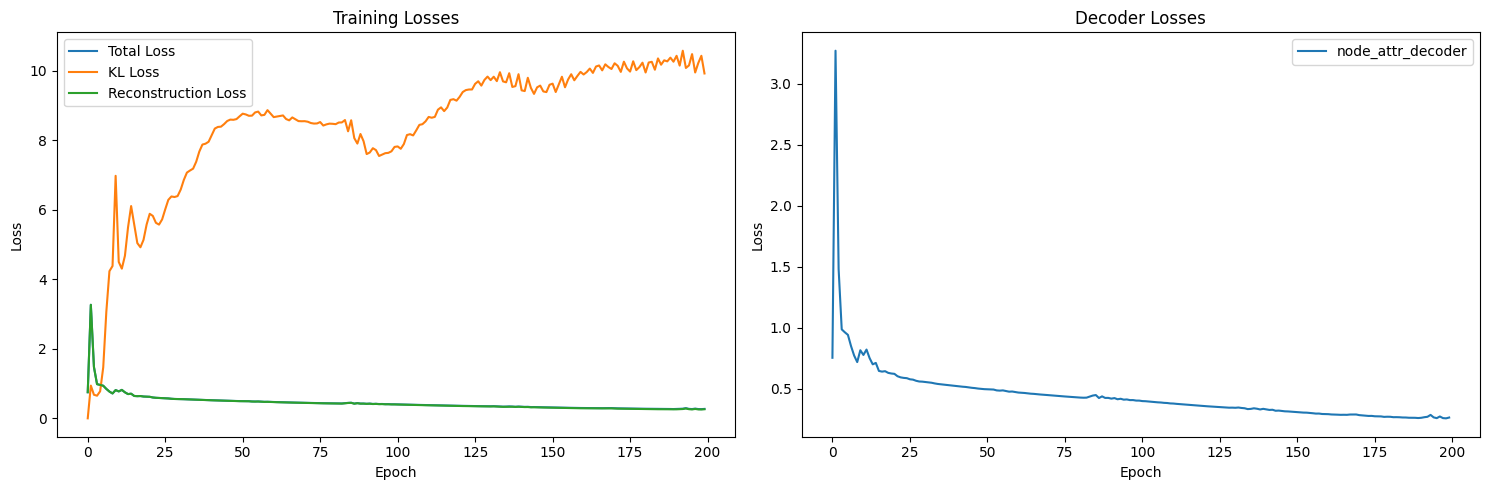

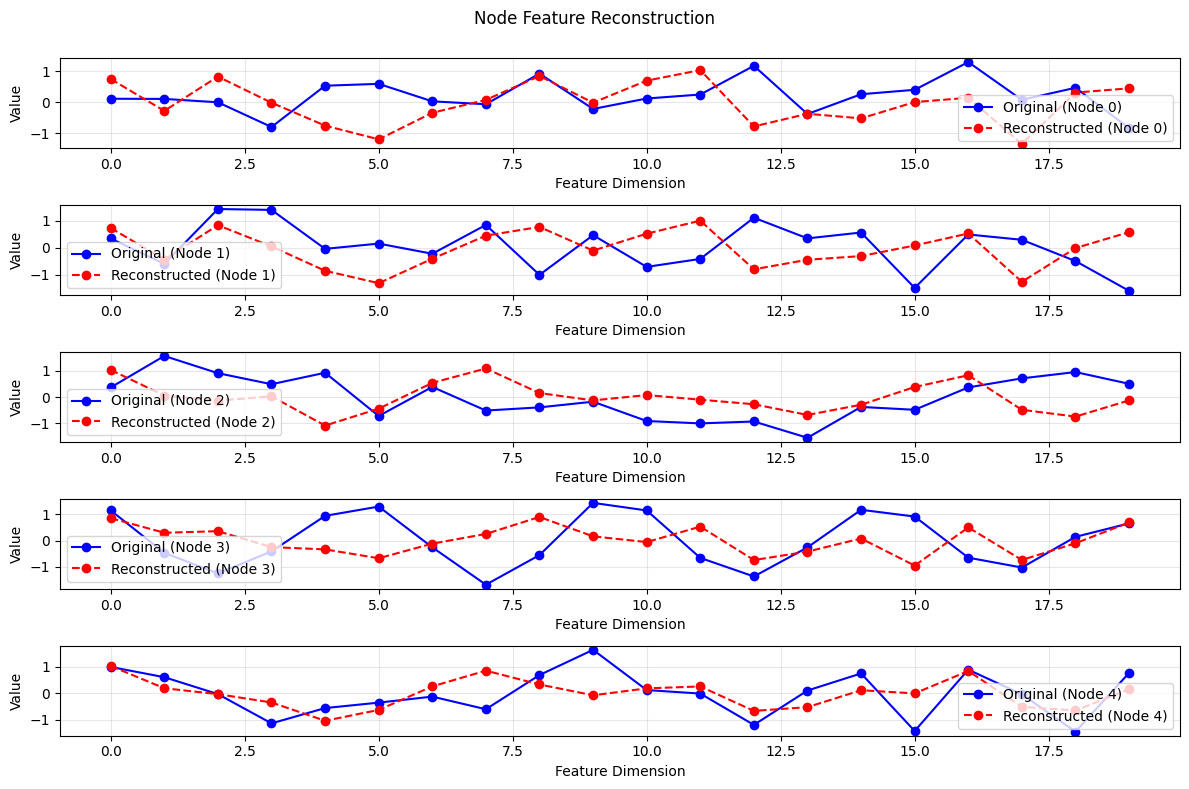

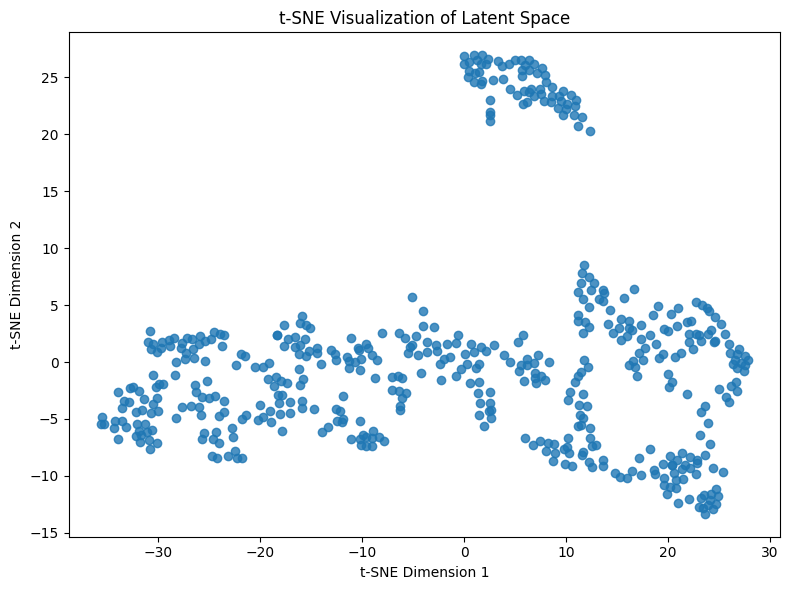

In [8]:
visualize_training(history_phase1)
#visualize_graph_reconstruction(model_phase1, single_graph)
visualize_node_features_reconstruction(model_phase1, single_graph, sample_features=dimP)
visualize_latent_space(model_phase1, [single_graph])

In [9]:
# model_phase1.construct_latent_manifold(
#     bounds=torch.tensor([[-5, 5]], dtype=torch.float32).repeat(latent_dim, 1),
#     force=True,
#     decoder_name="node_attr_decoder"
# )

Computing metric tensors for 10201 grid points...


Grid compute: 100%|██████████| 10201/10201 [00:06<00:00, 1507.30it/s]


Completed. Cached 10201 / 10201 points.


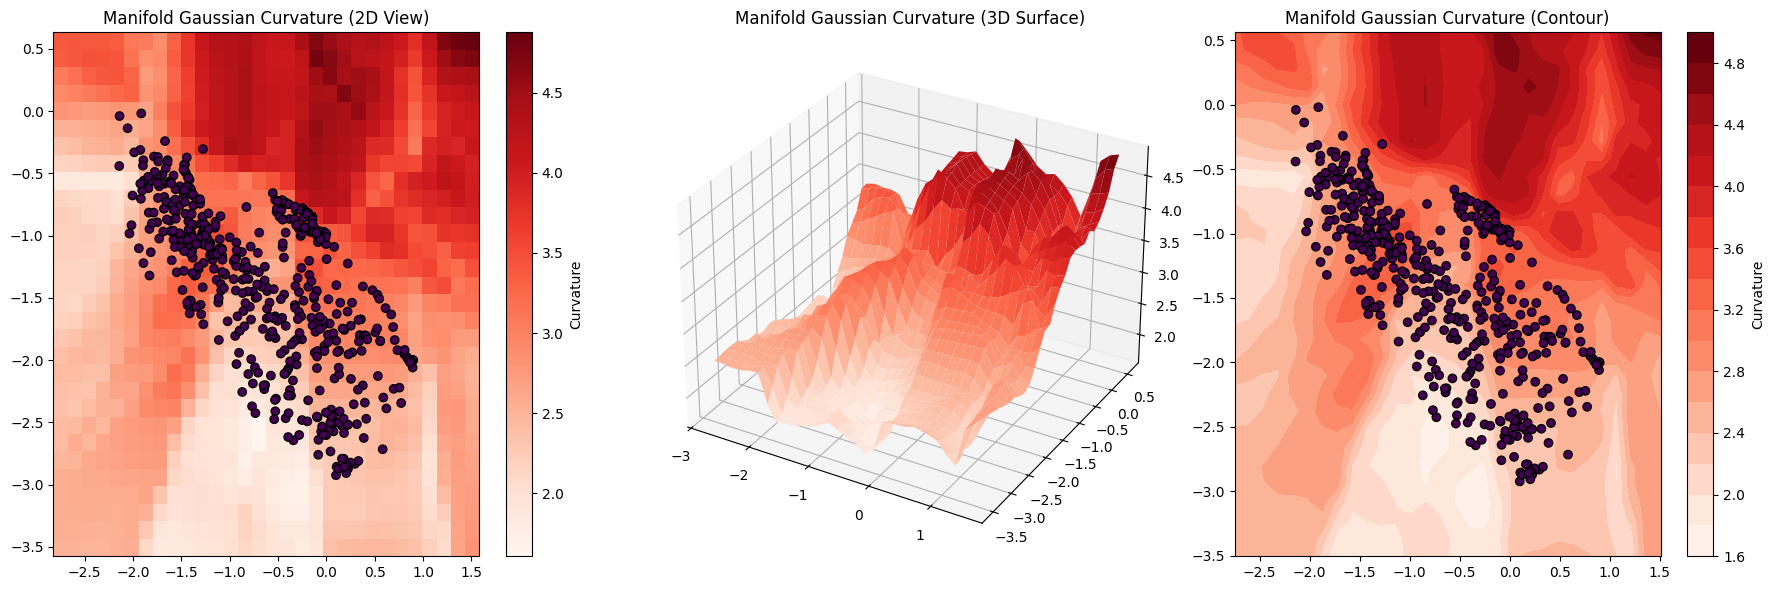

Calculating 124750 pairwise Riemannian distances using linear_interpolation_distance...


Calculating distances: 100%|██████████| 124750/124750 [01:03<00:00, 1978.44it/s]

Distance matrix calculation complete.


In [10]:
import copy
from framework.torchVersions.distanceApproximations import DistanceApproximations
model_phase1 = model_phase1.to('cpu')
model_phase2 = copy.deepcopy(model_phase1)

model_phase1.eval()

with torch.no_grad():
    x = single_graph.x.to(device)
    edge_index = single_graph.edge_index.to(device)
    latent_mu = model_phase1.encode(x, edge_index=edge_index)

latent_points = latent_mu[0]

model_phase1.set_compute_latent_manifold(True)
model_phase1.construct_latent_manifold(bounds=BoundedManifold.hypercube_bounds(latent_points, margin=0.2, relative=True), force=True)
model_phase1.get_latent_manifold().compute_full_grid_metric_tensor()
model_phase1.get_latent_manifold().visualize_manifold_curvature(data_points=latent_points)

with torch.no_grad():
    dists_phase1 = model_phase1.get_latent_manifold().create_riemannian_distance_matrix(latent_points, DistanceApproximations.linear_interpolation_distance, num_points=10)


### Phase 2

#### Distance based penalty

In [11]:
from framework.torchVersions.distanceApproximations import DistanceApproximations
import weakref
import random

class LatentDistanceDecoder(DecoderBase):
    """
    Fictive decoder that outputs latent codes but computes a meaningful loss 
    based on pairwise distances between connected nodes using Jacobian-based metrics.
    """
    def __init__(
        self, 
        latent_dim: int,
        distance_mode: str = "linear_interpolation",  # or "direct"
        num_integration_points: int = 25,
        metric_regularization: float = 1e-6,
        name: str = "latent_distance_decoder"
    ):
        super(LatentDistanceDecoder, self).__init__(latent_dim, name)
        
        self.distance_mode = distance_mode
        self.num_integration_points = num_integration_points
        self.metric_regularization = metric_regularization
        self.model = None  # Weak reference to the model instance

    def giveVAEInstance(self, model: VAE):
        self.model = weakref.ref(model)

    def forward(self, z: torch.Tensor, **kwargs) -> Dict[str, torch.Tensor]:
        """Forward pass - simply returns the latent codes (fictive decoder)"""
        return {"latent_codes": z.clone()}
        
    def _riemannian_distance(self, z1: torch.Tensor, z2: torch.Tensor) -> torch.Tensor:
        #print(f"[riemannian_distance] Computing pairwise distances for batch size {z.shape[0]}")
        #start_time = time.time()
        if self.model is None or self.model() is None:
            raise ValueError("Model instance not set. Call giveVAEInstance(model) first.")
        model = self.model()

        distances = []
        if z1.ndim == 1:
            z1 = z1.unsqueeze(0)
        if z2.ndim == 1:
            z2 = z2.unsqueeze(0)
        for i, (u_vec, v_vec) in enumerate(zip(z1, z2)):
            if self.distance_mode == "linear_interpolation":
                #d = DistanceApproximations.linear_interpolation_distance(model.get_latent_manifold(), u_vec, v_vec, 
                #                                                         num_points=self.num_integration_points)
                d = model.get_latent_manifold().linear_interpolation_distance(u_vec, v_vec, 
                                                                                num_points=self.num_integration_points)
            else:
                d = model.get_latent_manifold().exact_geodesic_distance(u_vec, v_vec)
            #print(f"  [distance] Sample {i}: {d.item():.4f}")
            distances.append(d)
        #print(f"[riemannian_distance] Done in {time.time() - start_time:.4f}s")
        return torch.stack(distances)
    
    def compute_loss(
                self,
                outputs: Dict[str, torch.Tensor],
                targets: Dict[str, torch.Tensor],
                negative_distance_weight: float = 1.0,
            ) -> torch.Tensor:
        if self.model is None or self.model() is None:
            raise ValueError("Model instance not set. Call giveVAEInstance(model) first.")

        z = outputs["latent_codes"]   # (N, D)
        N = z.size(0)
        # Removed: batched_dist = torch.vmap(self._riemannian_distance, in_dims=(0,0), out_dims=0)

        pos_pairs = []
        pos_weights = []

        if "edge_index" in targets:
            src, dst = targets["edge_index"]
            edge_labels = targets.get("edge_labels", None)
            for idx, (i, j) in enumerate(zip(src.tolist(), dst.tolist())):
                if i == j:
                    continue
                w = edge_labels[idx].item() if edge_labels is not None else 1.0
                if w > 0:
                    pos_pairs.append((i, j))
                    pos_weights.append(w)

        elif "adj_matrix" in targets:
            A = targets["adj_matrix"]
            ui, uj = torch.triu_indices(N, N, offset=1)
            weights = A[ui, uj]
            mask = weights > 0
            for i, j, w in zip(ui[mask].tolist(), uj[mask].tolist(), weights[mask].tolist()):
                pos_pairs.append((i, j))
                pos_weights.append(w)

        else:
            raise ValueError("Targets must contain either 'edge_index' or 'adj_matrix'")

        # Batch positive distances
        if pos_pairs:
            pos_pairs = torch.tensor(pos_pairs, device=z.device)
            pos_weights = torch.tensor(pos_weights, device=z.device)
            z_i = z[pos_pairs[:,0]]
            z_j = z[pos_pairs[:,1]]
            # Directly call _riemannian_distance (it handles its own batching)
            pos_dists = self._riemannian_distance(z_i, z_j) 
            total_pos   = (pos_weights * pos_dists).sum()
            sum_weights = pos_weights.sum()
            pos_loss    = total_pos / sum_weights
        else:
            pos_loss    = torch.tensor(0.0, device=z.device, requires_grad=True)
            sum_weights = 1.0

        # Build non-edge mask & sample negatives
        mask_nonedge = torch.ones((N, N), dtype=torch.bool, device=z.device)
        if pos_pairs.numel() > 0:
            mask_nonedge[pos_pairs[:,0], pos_pairs[:,1]] = False
            mask_nonedge[pos_pairs[:,1], pos_pairs[:,0]] = False
        mask_nonedge.fill_diagonal_(False)

        if negative_distance_weight > 0:
            num_neg = len(pos_pairs) if "edge_index" in targets else int((targets["adj_matrix"] != 0).sum().item() / 2)
            all_pairs = torch.nonzero(mask_nonedge, as_tuple=False)
            idxs      = torch.randint(0, all_pairs.size(0), (num_neg,), device=z.device)
            neg_pairs = all_pairs[idxs]

            z_i_neg = z[neg_pairs[:,0]]
            z_j_neg = z[neg_pairs[:,1]]
            # Directly call _riemannian_distance
            neg_dists = self._riemannian_distance(z_i_neg, z_j_neg)

            neg_penalties = 1.0 / (1.0 + neg_dists**2)

            neg_loss   = negative_distance_weight * neg_penalties.mean()
        else:
            neg_loss = torch.tensor(0.0, device=z.device, requires_grad=True)
        total_loss = pos_loss + neg_loss

        print(f"Loss: pos={pos_loss.item():.4f}, neg={neg_loss.item():.4f}, total={total_loss.item():.4f}")
        return total_loss


    # def compute_loss(
    #     self,
    #     outputs: Dict[str, torch.Tensor],
    #     targets: Dict[str, torch.Tensor],
    #     negative_distance_weight: float = 1,
    # ) -> torch.Tensor:
    #     """
    #     Compute loss based on:
    #     - Pairwise distances between connected nodes (positive edges)
    #     - Penalty for non-connected nodes being too close in the latent space (negative edges)
    #     """
    #     if self.model is None or self.model() is None:
    #         raise ValueError("Model instance not set. Call giveVAEInstance(model) first.")
    #     self.model().get_latent_manifold().compute_full_grid_metric_tensor()

    #     z = outputs["latent_codes"]
        
    #     total_pos_distance = 0.0
    #     total_neg_penalty = 0.0
    #     num_pos_edges = 0

    #     edge_set = set()  # To avoid sampling existing edges as negatives

    #     if "edge_index" in targets:
    #         edge_index = targets["edge_index"]
    #         num_negative_samples = edge_index.size(1)
    #         edge_labels = targets.get("edge_labels", None)
    #         src_nodes, dst_nodes = edge_index[0], edge_index[1]
            
    #         for idx in tqdm(range(edge_index.size(1)), desc="Positive Edges"):
    #             src_idx = src_nodes[idx].item()
    #             dst_idx = dst_nodes[idx].item()
                
    #             if src_idx == dst_idx:
    #                 continue

    #             edge_set.add((src_idx, dst_idx))
                
    #             if edge_labels is not None:
    #                 edge_weight = edge_labels[idx].item()
    #                 if edge_weight <= 0:
    #                     continue
    #             else:
    #                 edge_weight = 1.0

    #             distance = self._riemannian_distance(z[src_idx], z[dst_idx])
    #             total_pos_distance += edge_weight * distance
    #             num_pos_edges += edge_weight

    #         # Sample negative edges (no connection in edge_index)
    #         num_nodes = z.size(0)
    #         neg_samples = 0
    #         with tqdm(total=num_negative_samples, desc="Negative Sampling") as pbar:
    #             while neg_samples < num_negative_samples:
    #                 i = torch.randint(0, num_nodes, (1,)).item()
    #                 j = torch.randint(0, num_nodes, (1,)).item()
    #                 if i == j or (i, j) in edge_set or (j, i) in edge_set:
    #                     continue
    #                 distance = self._riemannian_distance(z[i], z[j])
    #                 penalty = 1.0 / (1.0 + (distance)**2)
    #                 total_neg_penalty += penalty
    #                 neg_samples += 1
    #                 pbar.update(1)

    #     elif "adj_matrix" in targets:
    #         adj_matrix = targets["adj_matrix"]
    #         num_negative_samples = int((adj_matrix != 0).sum().item() / 2)
    #         num_nodes = adj_matrix.size(0)

    #         for i in tqdm(range(num_nodes), desc="Positive Adjacency"):
    #             for j in range(i + 1, num_nodes):
    #                 edge_weight = adj_matrix[i, j].item()
    #                 if edge_weight > 0:
    #                     edge_set.add((i, j))
    #                     distance = self._riemannian_distance(z[i], z[j])
    #                     total_pos_distance += edge_weight * (distance**2)
    #                     num_pos_edges += edge_weight

    #         # Sample negative edges
    #         neg_samples = 0
    #         with tqdm(total=num_negative_samples, desc="Negative Sampling") as pbar:
    #             while neg_samples < num_negative_samples:
    #                 i = torch.randint(0, num_nodes, (1,)).item()
    #                 j = torch.randint(0, num_nodes, (1,)).item()
    #                 if i == j or (i, j) in edge_set or (j, i) in edge_set:
    #                     continue
    #                 distance = self._riemannian_distance(z[i], z[j])
    #                 penalty = 1.0 / (1.0 + distance)
    #                 total_neg_penalty += penalty
    #                 neg_samples += 1
    #                 pbar.update(1)

    #     else:
    #         raise ValueError("Targets must contain either 'edge_index' or 'adj_matrix'")
        
    #     gc.collect()

    #     # Compute final loss
    #     if num_pos_edges > 0:
    #         avg_pos_distance = total_pos_distance / num_pos_edges
    #         pos_loss = avg_pos_distance
    #     else:
    #         pos_loss = torch.tensor(0.0, device=z.device, requires_grad=True)

    #     neg_loss = negative_distance_weight * (total_neg_penalty / num_negative_samples) #* ((2 * num_negative_samples) / (num_nodes*(num_nodes-1)))
    #     print("Loss: pos=", pos_loss.sum(), " neg=", neg_loss.sum(), " (", (neg_loss.sum()*100)/(pos_loss.sum() + neg_loss.sum()) , "%) total=", pos_loss.sum() + neg_loss.sum())

    #     #return pos_loss * (neg_loss.detach() / (pos_loss.detach() + 1e-8)) + neg_loss
    #     return pos_loss + neg_loss


#### Laplacian based penalty

In [12]:
from framework.torchVersions.distanceApproximations import DistanceApproximations
import weakref
import time

class ManifoldHeatKernelDecoder(DecoderBase):
    """
    Fictive decoder that outputs latent codes but computes a meaningful loss 
    based on manifold heat kernel divergence with graph Laplacian.
    """
    def __init__(
        self, 
        latent_dim: int,
        distance_mode: str = "linear_interpolation",  # or "direct"
        num_integration_points: int = 25,
        metric_regularization: float = 1e-6,
        name: str = "manifold_heat_kernel_decoder",
        # Heat kernel specific parameters
        heat_time: Union[float, List[float]] = 1.0,  # Time parameter for heat kernel
        num_eigenvalues: int = 50,  # Number of eigenvalues to compute
        laplacian_regularization: float = 1e-8,
        heat_kernel_approximation: str = "spectral",  # "spectral" or "finite_difference"
        finite_diff_steps: int = 100,
        # Manifold Laplacian construction
        manifold_neighbors: int = 10,  # How many nearest neighbors to connect in manifold
        gaussian_bandwidth: float = 1.0,  # Bandwidth for Gaussian weights
    ):
        super(ManifoldHeatKernelDecoder, self).__init__(latent_dim, name)
        
        self.distance_mode = distance_mode
        self.num_integration_points = num_integration_points
        self.metric_regularization = metric_regularization
        self.model = None  # Weak reference to the model instance

        self.heat_times = [heat_time] if isinstance(heat_time, (float, int)) else list(heat_time)
        self.num_eigenvalues = num_eigenvalues
        self.laplacian_regularization = laplacian_regularization
        self.heat_kernel_approximation = heat_kernel_approximation
        self.finite_diff_steps = finite_diff_steps
        self.manifold_neighbors = manifold_neighbors
        self.gaussian_bandwidth = gaussian_bandwidth

    def giveVAEInstance(self, model: VAE):
        self.model = weakref.ref(model)

    def forward(self, z: torch.Tensor, **kwargs) -> Dict[str, torch.Tensor]:
        """Forward pass - simply returns the latent codes (fictive decoder)"""
        return {"latent_codes": z.clone()}
        
    def _riemannian_distance(self, z1: torch.Tensor, z2: torch.Tensor) -> torch.Tensor:
        #print(f"[riemannian_distance] Computing pairwise distances for batch size {z.shape[0]}")
        #start_time = time.time()
        if self.model is None or self.model() is None:
            raise ValueError("Model instance not set. Call giveVAEInstance(model) first.")
        model = self.model()

        distances = []
        if z1.ndim == 1:
            z1 = z1.unsqueeze(0)
        if z2.ndim == 1:
            z2 = z2.unsqueeze(0)
        if self.distance_mode == "linear_interpolation":
            return model.get_latent_manifold().linear_interpolation_distance(z1, z2, num_points=self.num_integration_points)
        else:
            for i, (u_vec, v_vec) in enumerate(zip(z1, z2)):
                if self.distance_mode == "linear_interpolation":
                    #d = DistanceApproximations.linear_interpolation_distance(model.get_latent_manifold(), u_vec, v_vec, 
                    #                                                         num_points=self.num_integration_points)
                    d = model.get_latent_manifold().linear_interpolation_distance(u_vec, v_vec, 
                                                                                    num_points=self.num_integration_points)
                else:
                    d = model.get_latent_manifold().exact_geodesic_distance(u_vec, v_vec)
                #print(f"  [distance] Sample {i}: {d.item():.4f}")
                distances.append(d)
        #print(f"[riemannian_distance] Done in {time.time() - start_time:.4f}s")
        return torch.stack(distances)

    def compute_manifold_laplacian(self, z: torch.Tensor, batch_size=8) -> torch.Tensor:
        """
        Compute the Laplace-Beltrami operator on the manifold using proper Riemannian distances
        Fully differentiable using Gaussian RBF weights
        """
        num_nodes = z.size(0)
        device = z.device
        
        # Compute all pairwise Riemannian distances
        print("Computing pairwise Riemannian distances...")
        # distances = torch.zeros(num_nodes, num_nodes, device=device, dtype=z.dtype)
        
        # for i in tqdm(range(num_nodes), desc="Computing distances"):
        #     for j in range(i + 1, num_nodes):
        #         dist = self._riemannian_distance(z[i], z[j])
        #         distances[i, j] = dist
        #         distances[j, i] = dist  # Symmetric

        distances = torch.zeros(num_nodes, num_nodes, device=z.device)
        row_indices, col_indices = torch.triu_indices(num_nodes, num_nodes, offset=1)
        total_pairs = len(row_indices)

        # Process in mini-batches
        for i in tqdm(range(0, total_pairs, batch_size), desc="Computing distances in batches"):
            batch_start = i
            batch_end = min(i + batch_size, total_pairs)

            # Get the current batch of indices
            current_row_indices = row_indices[batch_start:batch_end]
            current_col_indices = col_indices[batch_start:batch_end]

            # Extract the corresponding node embeddings for these pairs
            u_batch = z[current_row_indices]
            v_batch = z[current_col_indices]

            # Compute distances for this mini-batch
            # This is where your linear_interpolation_distance (aliased as _riemannian_distance) is called
            current_batch_distances = self._riemannian_distance(
                u_batch, v_batch
            )

            # Populate the distance matrix with the results of this batch
            distances[current_row_indices, current_col_indices] = current_batch_distances
            distances[current_col_indices, current_row_indices] = current_batch_distances # Symmetric

        
        # FIXED: Use differentiable Gaussian RBF weights instead of k-NN
        # This creates a fully connected graph with exponentially decaying weights
        weights = torch.exp(-distances**2 / (2 * self.gaussian_bandwidth**2))
        
        # Zero out diagonal (no self-connections)
        weights = weights * (1 - torch.eye(num_nodes, device=device))
        
        # Optional: Threshold very small weights to maintain some sparsity
        threshold = 1e-4
        weights = torch.where(weights > threshold, weights, torch.zeros_like(weights))
        
        # Create Laplacian: L = D - W where D is degree matrix
        degree = torch.sum(weights, dim=1)
        L_manifold = torch.diag(degree) - weights
        
        # Add regularization
        L_manifold += self.laplacian_regularization * torch.eye(num_nodes, device=device)
        
        return L_manifold
    
    def compute_heat_kernel_spectral(self, laplacian: torch.Tensor, t: Union[float, List[float]]) -> torch.Tensor:
        """
        Compute heat kernel using spectral decomposition: K(t) = exp(-t*L)
        """
        try:
            # Eigendecomposition of Laplacian
            eigenvals, eigenvecs = torch.linalg.eigh(laplacian)
            
            # Clamp eigenvalues to avoid numerical issues
            eigenvals = torch.clamp(eigenvals, min=0.0)
            
            # Take only the first num_eigenvalues for efficiency
            if self.num_eigenvalues < eigenvals.size(0):
                eigenvals = eigenvals[:self.num_eigenvalues]
                eigenvecs = eigenvecs[:, :self.num_eigenvalues]
            
            # Compute heat kernel: K(t) = V * exp(-t*Λ) * V^T
            if isinstance(t, (float, int)):
                exp_eigenvals = torch.exp(-t * eigenvals)
                return eigenvecs @ torch.diag(exp_eigenvals) @ eigenvecs.t()
            else:
                heat_kernels = []
                for t_i in t:
                    exp_eigenvals = torch.exp(-t_i * eigenvals)
                    K_t = eigenvecs @ torch.diag(exp_eigenvals) @ eigenvecs.t()
                    heat_kernels.append(K_t)
                return heat_kernels
                        
        except Exception as e:
            print(f"Warning: Spectral heat kernel computation failed: {e}")
            # Fallback to identity
            return torch.eye(laplacian.size(0), device=laplacian.device, dtype=laplacian.dtype)
    
    def compute_heat_kernel_finite_diff(self, laplacian: torch.Tensor, t: Union[float, List[float]]) -> torch.Tensor:
        """
        Compute heat kernel using finite difference approximation of exp(-t*L)
        """
        def compute_single_kernel(t_i):
            dt = t_i / self.finite_diff_steps
            K = torch.eye(laplacian.size(0), device=laplacian.device, dtype=laplacian.dtype)
            for _ in range(self.finite_diff_steps):
                K = K - dt * (laplacian @ K)
            return K

        if isinstance(t, (float, int)):
            return compute_single_kernel(t)
        return [compute_single_kernel(t_i) for t_i in t]
    
    def compute_graph_laplacian(self, targets: Dict[str, torch.Tensor]) -> torch.Tensor:
        """
        Compute the graph Laplacian from edge information
        """
        if "edge_index" in targets:
            edge_index = targets["edge_index"]
            num_nodes = targets.get("num_nodes", torch.max(edge_index) + 1)
            edge_weights = targets.get("edge_labels", torch.ones(edge_index.size(1)))
            
            # Create adjacency matrix
            adj = torch.zeros(num_nodes, num_nodes, device=edge_index.device, dtype=torch.float32)
            for i in range(edge_index.size(1)):
                src, dst = edge_index[0, i].item(), edge_index[1, i].item()
                weight = edge_weights[i].item() if edge_weights is not None else 1.0
                adj[src, dst] = weight
                adj[dst, src] = weight  # Symmetric
            
        elif "adj_matrix" in targets:
            adj = targets["adj_matrix"].float()
            num_nodes = adj.size(0)
        else:
            raise ValueError("Targets must contain either 'edge_index' or 'adj_matrix'")
        
        # Compute degree matrix
        degree = torch.sum(adj, dim=1)
        D = torch.diag(degree)
        
        # Laplacian: L = D - A
        laplacian = D - adj
        
        # Add small regularization
        laplacian += self.laplacian_regularization * torch.eye(num_nodes, device=adj.device)
        
        return laplacian
    
    def compute_heat_kernel_divergence(
        self,
        K_manifold: Union[torch.Tensor, List[torch.Tensor]],
        K_graph:    Union[torch.Tensor, List[torch.Tensor]]) -> torch.Tensor:
        """
        Compute divergence between manifold heat kernel and graph heat kernel
        Using Frobenius norm of the difference
        """
        # If we got lists of kernels, compute per‐t and average:
        if isinstance(K_manifold, (list, tuple)):
            divergences = [
                self.compute_heat_kernel_divergence(Km, Kg)
                for Km, Kg in zip(K_manifold, K_graph)
            ]
            # average (you can also sum or weight here)
            return torch.stack(divergences).sum()

        # Normalize both kernels to have same trace for fair comparison
        trace_manifold = torch.trace(K_manifold)
        trace_graph    = torch.trace(K_graph)
        
        if trace_manifold > 1e-8:
            K_manifold_norm = K_manifold * (trace_graph / trace_manifold)
        else:
            K_manifold_norm = K_manifold
        
        # Compute Frobenius norm of difference
        diff = K_manifold_norm - K_graph
        return torch.norm(diff, p='fro')
    
    def compute_loss(
        self,
        outputs: Dict[str, torch.Tensor],
        targets: Dict[str, torch.Tensor],
        heat_kernel_weight: float = 1,
    ) -> torch.Tensor:
        """
        Compute loss based on heat kernel divergence between manifold and graph
        """
        z = outputs["latent_codes"]
        num_nodes = z.size(0)
        
        #print("Computing graph Laplacian...")
        start_time = time.time()
        # Compute graph Laplacian
        L_graph = self.compute_graph_laplacian(targets)
        #print(f"[TIMER] Done in {time.time() - start_time:.4f}s")
        
        #print("Computing manifold Laplacian...")
        # Compute manifold Laplacian (this will compute Riemannian distances)
        start_time = time.time()
        L_manifold = self.compute_manifold_laplacian(z)
        #print(f"[TIMER] Done in {time.time() - start_time:.4f}s")
        
        #print("Computing heat kernels...")
        start_time = time.time()
        # Compute heat kernels
        if self.heat_kernel_approximation == "spectral":
            K_graph = self.compute_heat_kernel_spectral(L_graph, self.heat_times)
            K_manifold = self.compute_heat_kernel_spectral(L_manifold, self.heat_times)
        else:  # finite_difference
            K_graph = self.compute_heat_kernel_finite_diff(L_graph, self.heat_times)
            K_manifold = self.compute_heat_kernel_finite_diff(L_manifold, self.heat_times)
        #print(f"[TIMER] Done in {time.time() - start_time:.4f}s")
        
        #print("Computing heat kernel divergence...")
        # Compute divergence
        start_time = time.time()
        divergence = self.compute_heat_kernel_divergence(K_manifold, K_graph)
        #print(f"[TIMER] Done in {time.time() - start_time:.4f}s")
        
        # Total loss
        total_loss = heat_kernel_weight * divergence
        
        #print(f"Heat kernel divergence: {(divergence.item()):.6f}")
        print(f"Total Laplacian loss: {(total_loss.item()):.6f}")
        
        return total_loss


=== Starting Phase 2: Freezing encoder and adding adjacency decoder ===
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 990.57it/s] 


Total Laplacian loss: 8.536440
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 928.73it/s] 


Total Laplacian loss: 8.678384
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:17<00:00, 902.58it/s] 


Total Laplacian loss: 8.050689
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 940.03it/s] 


Total Laplacian loss: 8.561690
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 934.35it/s] 


Total Laplacian loss: 7.915624
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 921.64it/s] 


Total Laplacian loss: 7.255593
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 942.98it/s] 


Total Laplacian loss: 6.312701
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 951.51it/s] 


Total Laplacian loss: 6.322818
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 941.92it/s] 


Total Laplacian loss: 5.917714
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 990.66it/s] 


Total Laplacian loss: 5.604043
Phase 2 - Epoch 10/100 - Loss: 2.0000, KL: 5.6125 (weight: 0.0000), Adj: 5.6040, Node: 0.6560
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:17<00:00, 915.84it/s] 


Total Laplacian loss: 4.720006
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 967.29it/s] 


Total Laplacian loss: 4.390890
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 972.77it/s] 


Total Laplacian loss: 4.308112
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 946.31it/s] 


Total Laplacian loss: 4.098733
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 930.63it/s] 


Total Laplacian loss: 3.950918
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 920.32it/s] 


Total Laplacian loss: 4.024666
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 938.36it/s] 


Total Laplacian loss: 4.016795
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 1008.23it/s]


Total Laplacian loss: 4.042495
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 966.04it/s] 


Total Laplacian loss: 3.890087
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 1027.78it/s]


Total Laplacian loss: 3.898265
Phase 2 - Epoch 20/100 - Loss: 2.0000, KL: 5.6125 (weight: 0.0000), Adj: 3.8983, Node: 0.6099
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 997.68it/s] 


Total Laplacian loss: 3.892029
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 954.34it/s] 


Total Laplacian loss: 3.510177
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 941.41it/s] 


Total Laplacian loss: 3.766047
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 967.67it/s] 


Total Laplacian loss: 3.709074
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 1004.76it/s]


Total Laplacian loss: 3.707668
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 978.80it/s] 


Total Laplacian loss: 4.037009
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 958.75it/s] 


Total Laplacian loss: 3.970222
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 959.62it/s] 


Total Laplacian loss: 4.122205
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 1011.67it/s]


Total Laplacian loss: 3.691690
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 951.43it/s] 


Total Laplacian loss: 4.296776
Phase 2 - Epoch 30/100 - Loss: 2.0000, KL: 5.6125 (weight: 0.0000), Adj: 4.2968, Node: 0.5903
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 966.28it/s] 


Total Laplacian loss: 3.695599
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 1013.90it/s]


Total Laplacian loss: 3.493950
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 988.17it/s] 


Total Laplacian loss: 3.512152
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 972.47it/s] 


Total Laplacian loss: 3.589020
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 995.29it/s] 


Total Laplacian loss: 3.686208
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 989.41it/s] 


Total Laplacian loss: 3.517066
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 992.20it/s] 


Total Laplacian loss: 3.509483
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 954.08it/s] 


Total Laplacian loss: 3.371464
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 982.11it/s] 


Total Laplacian loss: 3.599718
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 985.59it/s] 


Total Laplacian loss: 3.645674
Phase 2 - Epoch 40/100 - Loss: 2.0000, KL: 5.6125 (weight: 0.0000), Adj: 3.6457, Node: 0.5752
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 955.50it/s] 


Total Laplacian loss: 3.746987
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 979.75it/s] 


Total Laplacian loss: 3.508901
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 1019.53it/s]


Total Laplacian loss: 3.903746
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 956.84it/s] 


Total Laplacian loss: 3.733854
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 1001.93it/s]


Total Laplacian loss: 3.622417
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 953.41it/s] 


Total Laplacian loss: 4.075214
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 976.02it/s] 


Total Laplacian loss: 3.486774
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 984.53it/s] 


Total Laplacian loss: 3.469447
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 986.44it/s] 


Total Laplacian loss: 3.305680
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 1009.37it/s]


Total Laplacian loss: 3.331153
Phase 2 - Epoch 50/100 - Loss: 2.0000, KL: 5.6125 (weight: 0.0000), Adj: 3.3312, Node: 0.5682
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 939.32it/s] 


Total Laplacian loss: 3.573130
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 985.13it/s] 


Total Laplacian loss: 3.552089
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 979.24it/s] 


Total Laplacian loss: 3.964320
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 968.56it/s] 


Total Laplacian loss: 3.126190
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 973.20it/s] 


Total Laplacian loss: 3.718599
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 968.99it/s] 


Total Laplacian loss: 3.820981
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 982.30it/s] 


Total Laplacian loss: 3.269213
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 956.96it/s] 


Total Laplacian loss: 3.248805
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:17<00:00, 909.97it/s] 


Total Laplacian loss: 3.277597
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:19<00:00, 808.57it/s] 


Total Laplacian loss: 3.121175
Phase 2 - Epoch 60/100 - Loss: 2.0000, KL: 5.6125 (weight: 0.0000), Adj: 3.1212, Node: 0.5613
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:18<00:00, 856.26it/s] 


Total Laplacian loss: 3.413850
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 935.55it/s] 


Total Laplacian loss: 3.265440
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 946.93it/s] 


Total Laplacian loss: 3.105357
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 931.19it/s] 


Total Laplacian loss: 3.321711
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 928.90it/s] 


Total Laplacian loss: 3.149659
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 934.59it/s] 


Total Laplacian loss: 3.233991
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 921.74it/s] 


Total Laplacian loss: 3.174395
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 948.31it/s] 


Total Laplacian loss: 3.048854
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 958.51it/s] 


Total Laplacian loss: 3.244200
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 919.10it/s] 


Total Laplacian loss: 3.139218
Phase 2 - Epoch 70/100 - Loss: 2.0000, KL: 5.6125 (weight: 0.0000), Adj: 3.1392, Node: 0.5547
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 954.83it/s] 


Total Laplacian loss: 3.094524
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 928.41it/s] 


Total Laplacian loss: 3.100849
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 935.09it/s] 


Total Laplacian loss: 3.102705
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 979.86it/s] 


Total Laplacian loss: 3.029860
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 944.06it/s] 


Total Laplacian loss: 2.979604
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 921.84it/s] 


Total Laplacian loss: 3.305021
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 973.44it/s] 


Total Laplacian loss: 3.158582
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 945.05it/s] 


Total Laplacian loss: 2.970155
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 931.57it/s] 


Total Laplacian loss: 3.387754
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 933.90it/s] 


Total Laplacian loss: 3.170211
Phase 2 - Epoch 80/100 - Loss: 2.0000, KL: 5.6125 (weight: 0.0000), Adj: 3.1702, Node: 0.5512
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 925.09it/s] 


Total Laplacian loss: 3.168662
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 963.82it/s] 


Total Laplacian loss: 2.938804
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 948.66it/s] 


Total Laplacian loss: 2.947369
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 921.22it/s] 


Total Laplacian loss: 3.144669
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 940.26it/s] 


Total Laplacian loss: 2.944911
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 926.00it/s] 


Total Laplacian loss: 2.927808
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 934.02it/s] 


Total Laplacian loss: 3.355534
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 972.12it/s] 


Total Laplacian loss: 2.911272
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 956.96it/s] 


Total Laplacian loss: 3.101312
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 944.94it/s] 


Total Laplacian loss: 2.953930
Phase 2 - Epoch 90/100 - Loss: 2.0000, KL: 5.6125 (weight: 0.0000), Adj: 2.9539, Node: 0.5473
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 973.26it/s] 


Total Laplacian loss: 3.030441
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:17<00:00, 900.05it/s] 


Total Laplacian loss: 2.862021
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 927.98it/s] 


Total Laplacian loss: 3.122410
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 957.54it/s] 


Total Laplacian loss: 2.942712
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 938.73it/s] 


Total Laplacian loss: 3.026438
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:15<00:00, 978.49it/s] 


Total Laplacian loss: 3.005509
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 942.79it/s] 


Total Laplacian loss: 2.983406
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 959.74it/s] 


Total Laplacian loss: 2.985695
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:17<00:00, 896.80it/s] 


Total Laplacian loss: 2.935521
Computing pairwise Riemannian distances...


Computing distances in batches: 100%|██████████| 15594/15594 [00:16<00:00, 956.22it/s] 


Total Laplacian loss: 2.941228
Phase 2 - Epoch 100/100 - Loss: 2.0000, KL: 5.6125 (weight: 0.0000), Adj: 2.9412, Node: 0.5461

=== Phase 2 Complete ===


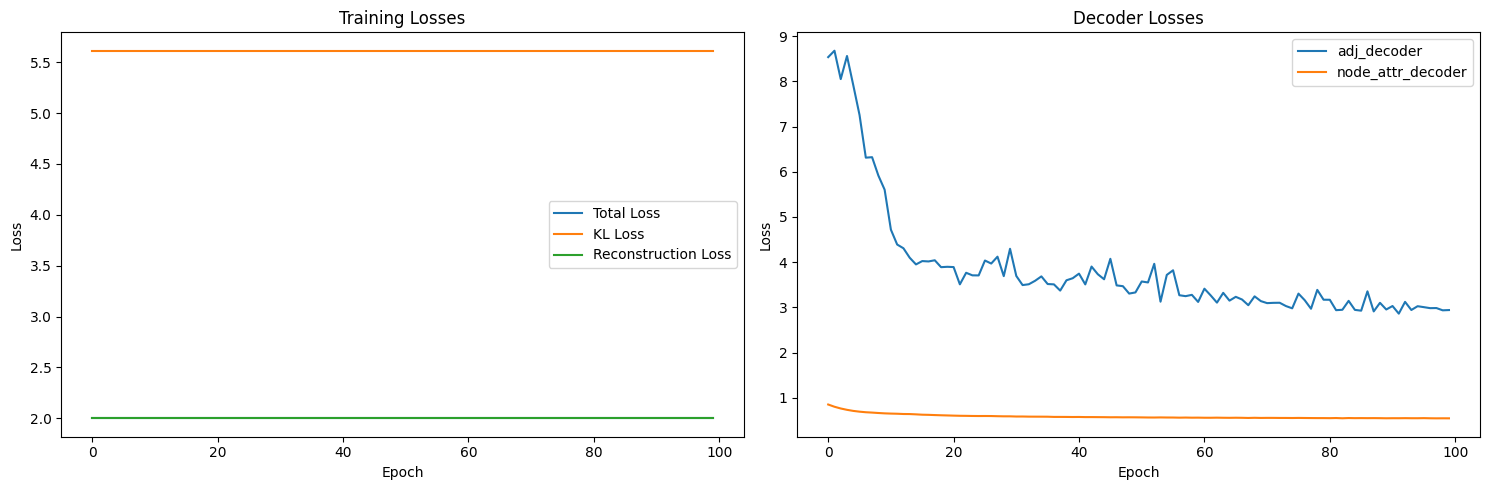

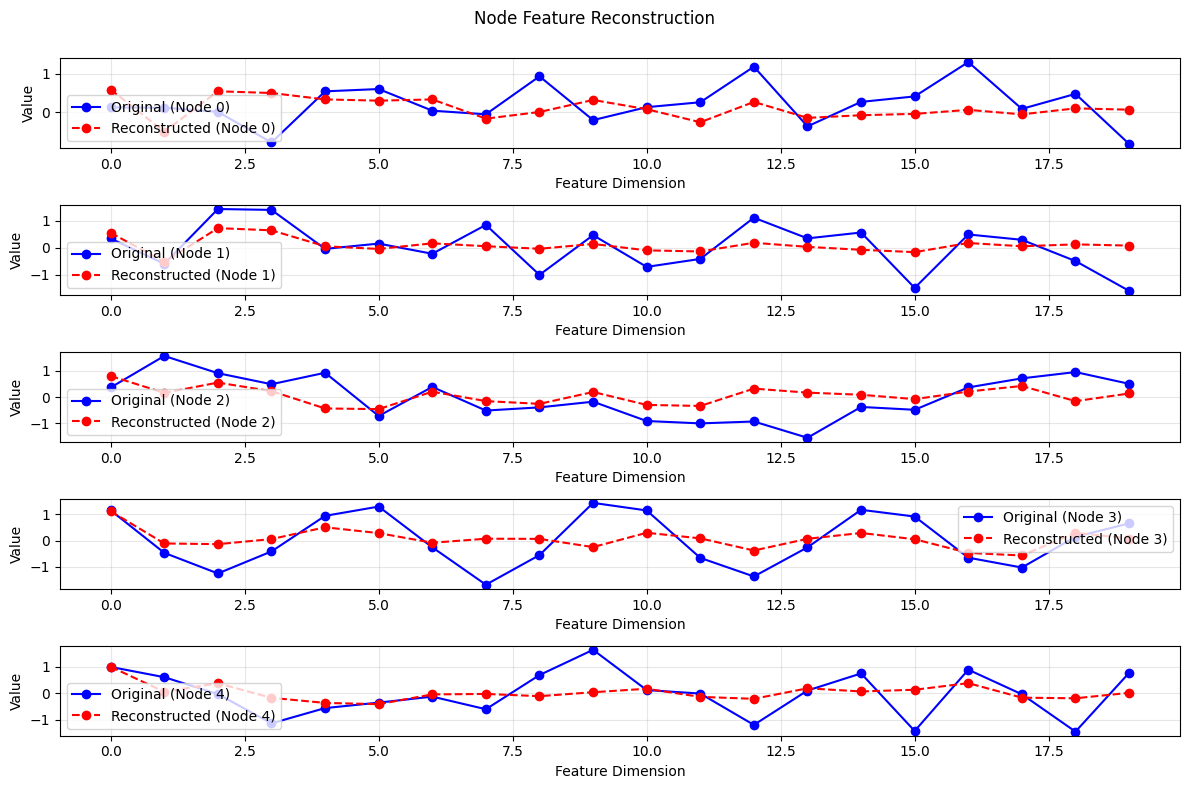

In [13]:
lr_phase2 = 0.0001

print("=== Starting Phase 2: Freezing encoder and adding adjacency decoder ===")
# from torch.profiler import profile, schedule, ProfilerActivity, tensorboard_trace_handler

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
#              record_shapes=True,
#              profile_memory=True,
#              with_stack=True) as prof:

model_phase2.set_compute_latent_manifold(True)
model_phase2.construct_latent_manifold(bounds=BoundedManifold.hypercube_bounds(latent_points, margin=0.2, relative=True), force=True)
#model_phase2.get_latent_manifold().compute_full_grid_metric_tensor()

# distance_decoder = LatentDistanceDecoder(
#     latent_dim=latent_dim,
#     distance_mode="linear_interpolation",  # or "direct"
#     name="adj_decoder",
#     num_integration_points=10
# )

distance_decoder = ManifoldHeatKernelDecoder(
    latent_dim=latent_dim,
    heat_time=torch.logspace(start=-1, end=2, steps=10).tolist(),  # Adjust for local vs global structure
    num_eigenvalues=150,
    heat_kernel_approximation="spectral",
    num_integration_points=10,
    name="adj_decoder",
)


# distance_decoder = LatentDistanceDecoder(
#     latent_dim=latent_dim,
#     reference_decoder=node_decoder,
#     grid_size=32, z_min=-2.0, z_max=2.0, 
#     metric_regularization=1e-5)

# Add to your GraphVAE model
model_phase2.add_decoder(distance_decoder)

# Set reference decoder (the node attribute decoder)
#model_phase2.get_decoder("adj_decoder").giveManifoldInstance(model_phase2.get_latent_manifold())
model_phase2.get_decoder("adj_decoder").giveVAEInstance(model_phase2)

# Reset KL scheduler for phase 2
model_phase2.kl_scheduler = KLAnnealingScheduler(
    anneal_start=0,  
    anneal_end=0,
    anneal_steps=phase2_epochs * len(single_graph_list),
    anneal_type='linear'
)

# Phase 2 training
history_phase2 = train_phase2(
    model=model_phase2,
    data_loader=single_graph_list,
    num_epochs=phase2_epochs,
    lr=lr_phase2,
    weight_decay=1e-5,
    decoder_weights={"adj_decoder": -1, "node_attr_decoder":-1 },
    verbose=True,
    device=device,
)

print("\n=== Phase 2 Complete ===")
visualize_training(history_phase2)
#visualize_graph_reconstruction(model_phase1, single_graph)
visualize_node_features_reconstruction(model_phase2, single_graph, sample_features=dimP)
#visualize_latent_space(model_phase1, [single_graph])
#plot_curvature(model_phase1, single_graph)


# Combine histories
combined_history = {
    "phase1": history_phase1,
    "phase2": history_phase2
}

# Unfreeze encoder for potential further use
model_phase1.set_encoder_freeze(False)

# try:
#     from torch.cuda._memory_viz import profile_plot
#     with open('memory_timeline_single_step.html', 'w') as f:
#         f.write(profile_plot(prof))
#     print("Memory timeline plot exported to memory_timeline_single_step.html.")
# except ImportError:
#     print("torch.cuda._memory_viz not found. Skipping memory timeline plot generation.")


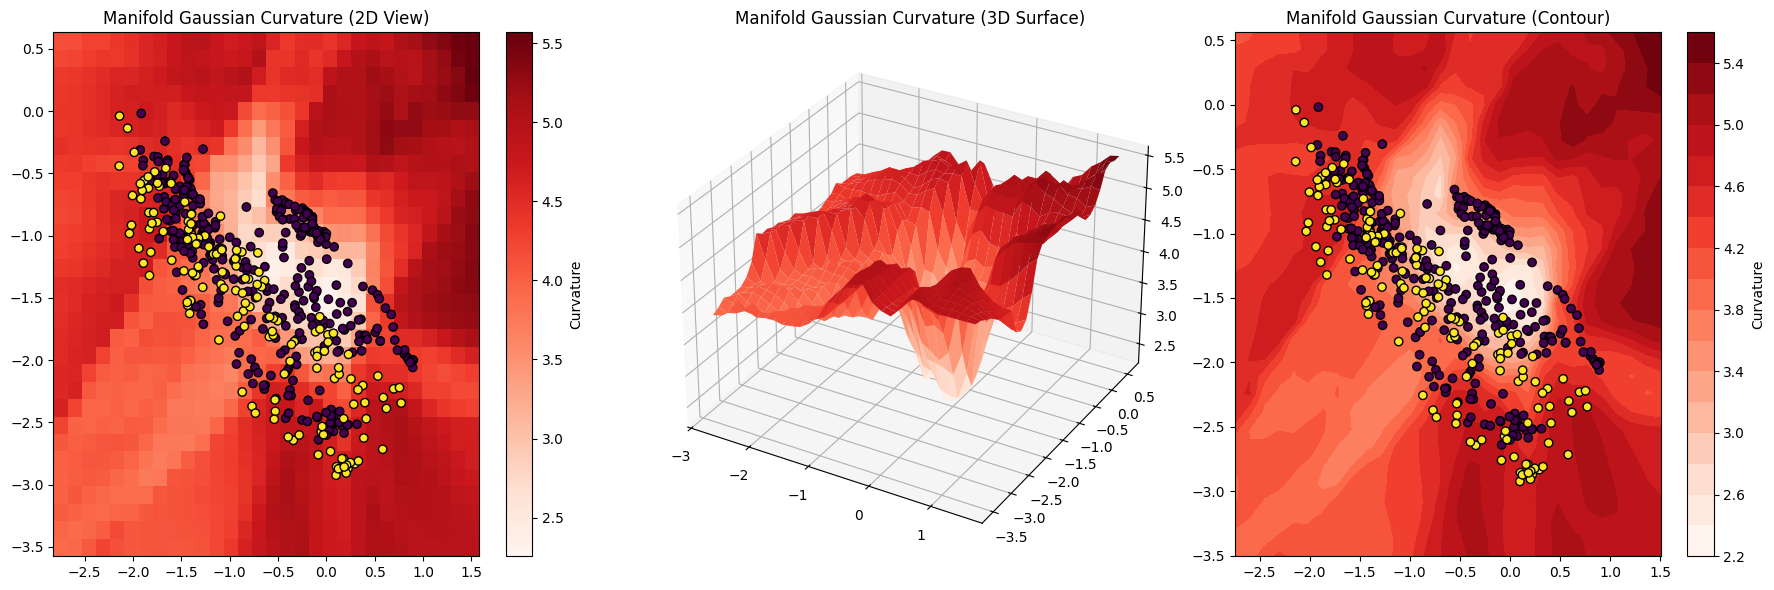

In [23]:
model_phase2.get_latent_manifold().visualize_manifold_curvature(data_points=latent_points,
                                                                labels=torch.tensor([0]*350 + [1]*150))


In [26]:
merged_history.keys()

dict_keys(['total_loss', 'kl_loss', 'recon_loss', 'decoder_losses'])

In [28]:
merged_history = {}
for key in history_phase1.keys():
  if isinstance(history_phase1[key], list):
    merged_history[key] = history_phase1[key] + history_phase2[key]
  else:
     merged_history[key] = dict()
     for key2 in history_phase1[key].keys():
        merged_history[key][key2] = history_phase1[key][key2] + history_phase2[key][key2]
      
     for key2 in history_phase2[key].keys():
        if key2 not in history_phase1[key].keys():
          merged_history[key][key2] = [np.nan]*len(history_phase1["kl_loss"]) + history_phase2[key][key2]

visualize_training(merged_history)


In [15]:
with torch.no_grad():
    dists_phase2 = model_phase2.get_latent_manifold().create_riemannian_distance_matrix(latent_points, DistanceApproximations.linear_interpolation_distance, num_points=10)

Calculating 124750 pairwise Riemannian distances using linear_interpolation_distance...


Calculating distances: 100%|██████████| 124750/124750 [01:02<00:00, 2010.84it/s]

Distance matrix calculation complete.


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def plot_correlogram(*correlation_matrices, titles=None, cmap='viridis', organ_names_dict=None, remove_diagonal=False, triangular=False, annot=False):
    """
    Plots multiple correlograms (NumPy arrays) in a row as subplots with a shared color scale and adjusted axis labels.

    Args:
        *correlation_matrices: Variable number of NumPy arrays (correlation matrices).
        titles: Optional list of titles for each correlogram. If None, default titles are used.
        cmap: Optional colormap for the heatmaps.
        organ_names_dict: Optional dictionary mapping indices to organ names. If provided, axis labels are adjusted.
    """

    num_matrices = len(correlation_matrices)

    if num_matrices == 0:
        print("No correlation matrices provided.")
        return

    if titles is None:
        titles = [f"Correlogram {i+1}" for i in range(num_matrices)]
    elif len(titles) != num_matrices:
        print("Number of titles does not match number of matrices.")
        titles = [f"Correlogram {i+1}" for i in range(num_matrices)]

    # Find the global min and max for the color scale
    global_min = min(np.nanmin(corr_matrix) for corr_matrix in correlation_matrices)
    global_max = max(np.nanmax(corr_matrix) for corr_matrix in correlation_matrices)

    if num_matrices == 1:
        plt.figure(figsize=(8 + 2*(organ_names_dict is not None), 8 + 2*(organ_names_dict is not None)))
    else:
        plt.figure(figsize=(12 * num_matrices, 12))

    for i, corr_matrix in enumerate(correlation_matrices):
        if remove_diagonal:
            np.fill_diagonal(corr_matrix, np.nan)
        if triangular:
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        else:
            mask = False

        plt.subplot(1, num_matrices, i + 1)
        ax = sns.heatmap(
            corr_matrix,
            annot=annot,
            cmap=cmap,
            fmt='.2f',
            linewidths=0,
            cbar_kws={"shrink": 0.8},
            annot_kws={"size": 12},
            square=True,
            linecolor='white',
            vmin=global_min,  # Set global min
            vmax=global_max,   # Set global max
            mask=mask
        )
        plt.title(titles[i])

        if organ_names_dict is not None:
            num_organs = corr_matrix.shape[0]
            if len(organ_names_dict) == num_organs:
                organ_names = [organ_names_dict.get(j, f"Index {j}") for j in range(num_organs)]
                ax.set_xticks(np.array(range(num_organs))+0.5)
                ax.set_xticklabels(organ_names, rotation=90)
                ax.set_yticks(np.array(range(num_organs))+0.5)
                ax.set_yticklabels(organ_names, rotation=0)
            else:
                print(f"Warning: Length of organ_names_dict ({len(organ_names_dict)}) does not match matrix size ({num_organs}).")

    plt.tight_layout()
    plt.show()
    return plt

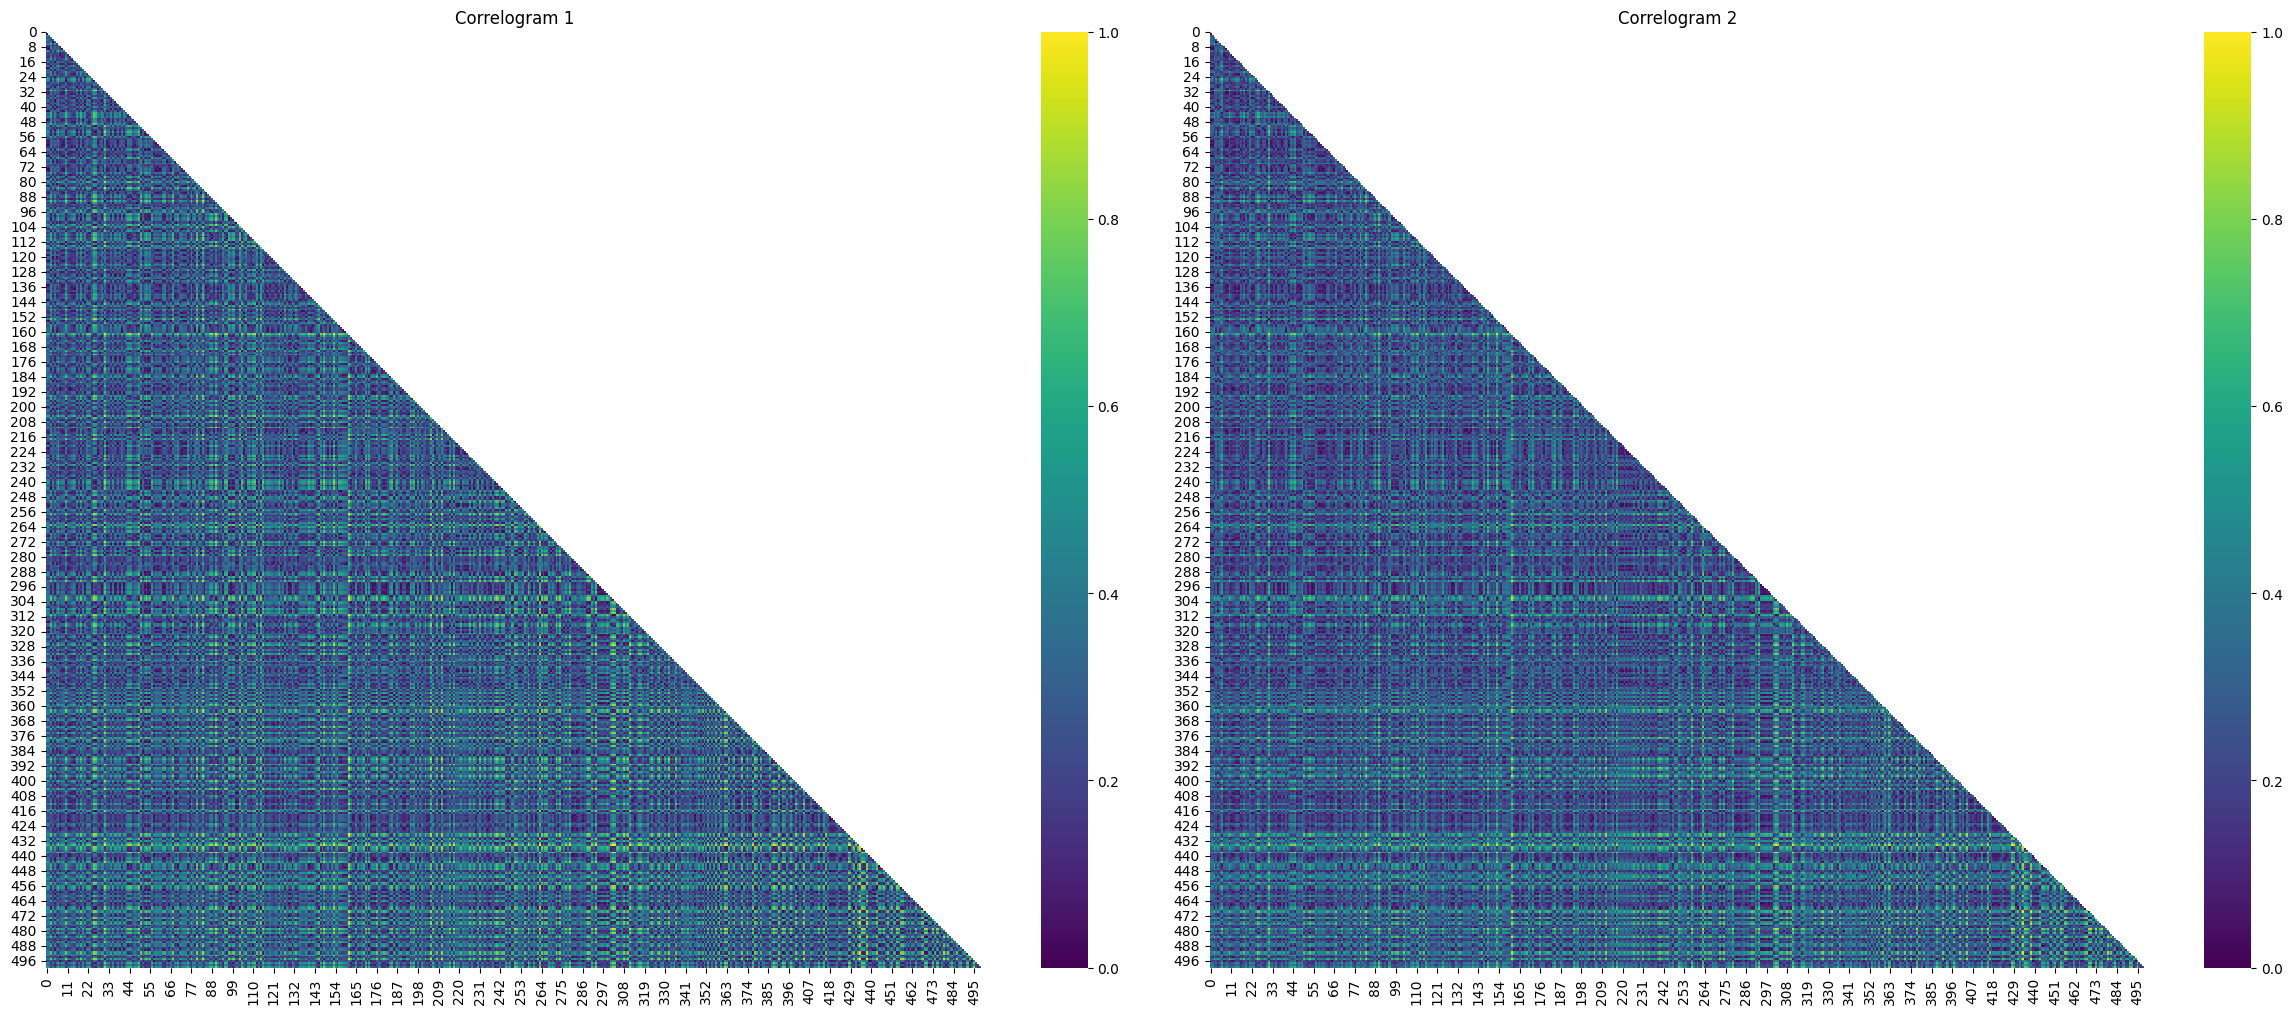

In [21]:
if isinstance(dists_phase1, torch.Tensor):
    dists_phase1 = dists_phase1.detach().numpy()
if isinstance(dists_phase2, torch.Tensor):
    dists_phase2 = dists_phase2.detach().numpy()

res = np.abs((dists_phase1 - dists_phase2))

_ = plot_correlogram(dists_phase1/np.max(np.where(dists_phase1 > 0, dists_phase1, 0)), dists_phase2/np.max(np.where(dists_phase2 > 0, dists_phase2, 0)), remove_diagonal=True, triangular=True)

_ = plot_correlogram(res/np.max(res))

In [20]:
plt.figure(figsize=(10, 6)) # Set the size of the plot for better readability

plt.plot(np.sum(res, axis=0), marker='o', linestyle='-')

# Add a horizontal line at y=0

# --- Customize the Plot ---
plt.xlabel('Nodes') # Label for the x-axis
plt.ylabel('Residuals') # Label for the y-axis, updated to reflect the ratio
plt.title('Our residual') # Title of the plot, updated
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for easier reading
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping
plt.show()